In [1]:
from functools import reduce

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from datetime import datetime

from db_queries import get_location_metadata

import statsmodels.api as sm

pd.options.display.max_rows = 200

import warnings
warnings.simplefilter('ignore')


In [2]:
def prep_model_data(df, rate_var):
    df = df.sort_values('Date').set_index('Date')
    df = df.asfreq('D', method='pad')
    
    df[rate_var] = df[rate_var].fillna(method='pad')
    df.loc[df[rate_var] == 0, rate_var] = 0.1 / df['population'].unique().item()
    df[f'ln({rate_var.lower()})'] = np.log(df[rate_var])
    
    df = df.reset_index()
    
    return df


def model_location(death_df, case_df, test_df, death_rate_threshold=-15):
    death_df = prep_model_data(death_df, 'Death rate')
    del death_df['population']
    case_df = prep_model_data(case_df, 'Confirmed case rate')
    case_df['Date'] = case_df['Date'].apply(lambda x: x + pd.Timedelta(days=8))
    del case_df['population']
    test_df = prep_model_data(test_df, 'Testing rate')
    test_df['Date'] = test_df['Date'].apply(lambda x: x + pd.Timedelta(days=8))
    
    df = reduce(lambda x, y: pd.merge(x, y), [death_df, case_df, test_df])
    df = df.loc[df['ln(death rate)'] >= death_rate_threshold]
    df = df.loc[~df[['ln(confirmed case rate)', 'ln(testing rate)']].isnull().any(axis=1)]
    df = df.reset_index(drop=True)
    df['intercept'] = 1
    
    dep_var = 'ln(death rate)'
    indep_vars = ['intercept', 'ln(confirmed case rate)', 'ln(testing rate)']
    
    mod = sm.OLS(df[dep_var], df[indep_vars]).fit()
    pred_df = case_df.merge(test_df)
    pred_df = pred_df.merge(death_df, how='left')
    pred_df['intercept'] = 1
    pred_df['Predicted ln(death rate)'] = mod.predict(pred_df[indep_vars])

    return pred_df[['location_id', 'Date', 'population'] + \
                   ['Predicted ln(death rate)', dep_var] + indep_vars]


def load_data():
    # location information
    loc_df = get_location_metadata(location_set_id=111, location_set_version_id=664)
    #loc_df = loc_df.loc[loc_df['path_to_top_parent'].str.startswith('102,')]
    loc_df = loc_df.loc[loc_df['most_detailed'] == 1]
    loc_df = loc_df[['location_id', 'location_name']].reset_index(drop=True)

    # cases and deaths
    full_df = pd.read_csv('/ihme/covid-19/model-inputs/best/full_data.csv')
    full_df['Date'] = pd.to_datetime(full_df['Date'])
    full_df = full_df.loc[full_df['location_id'].isin(loc_df['location_id'].to_list())]
    full_df['location_id'] = full_df['location_id'].astype(int)
    full_df['Confirmed case rate'] = full_df['Confirmed'] / full_df['population']
    full_df = full_df[['location_id', 'Date', 'Confirmed case rate', 'Death rate', 'population']].reset_index(drop=True)
    full_df = full_df.sort_values(['location_id', 'Date']).reset_index(drop=True)
    full_df = full_df.loc[~full_df[['Confirmed case rate', 'Death rate']].isnull().any(axis=1)]
    case_df = full_df[['location_id', 'Date', 'Confirmed case rate', 'population']].copy()
    case_df['Date'] = case_df['Date'].apply(lambda x: x + pd.Timedelta(days=8))
    death_df = full_df[['location_id', 'Date', 'Death rate', 'population']].copy()

    # testing
    test_df = testing_io()
    test_df = test_df.loc[test_df['location_id'].isin(loc_df['location_id'].to_list())]
    test_df = test_df.loc[~test_df['Tests'].isnull()]
    test_df['location_id'] = test_df['location_id'].astype(int)
    test_df = test_df.merge(full_df[['location_id', 'population']].drop_duplicates())
    test_df['Testing rate'] = test_df['Tests'] / test_df['population']
    test_df = test_df[['location_id', 'Date', 'Testing rate', 'population']]
    test_df = test_df.sort_values(['location_id', 'Date']).reset_index(drop=True)
    
    return loc_df, death_df, case_df, test_df


def get_daily(df, cum_var, daily_var):
    df = df.sort_values(['location_id', 'Date'])
    first_day = (df['Date'] == df.groupby('location_id')['Date'].transform(min)).values
    delta = df[cum_var].values[1:] - df[cum_var].values[:-1]
    delta = delta[~first_day[1:]]
    df[daily_var] = df[cum_var]
    df.loc[~first_day, daily_var] = delta
    
    return df


def main():
    loc_df, death_df, case_df, test_df = load_data()


In [3]:
loc_df, death_df, case_df, test_df = load_data()


In [4]:
pred_df =  pd.concat([model_location(death_df.loc[death_df['location_id'] == location_id].reset_index(drop=True), 
                           case_df.loc[case_df['location_id'] == location_id].reset_index(drop=True), 
                           test_df.loc[test_df['location_id'] == location_id].reset_index(drop=True))
                       for location_id in test_df.location_id.unique()])


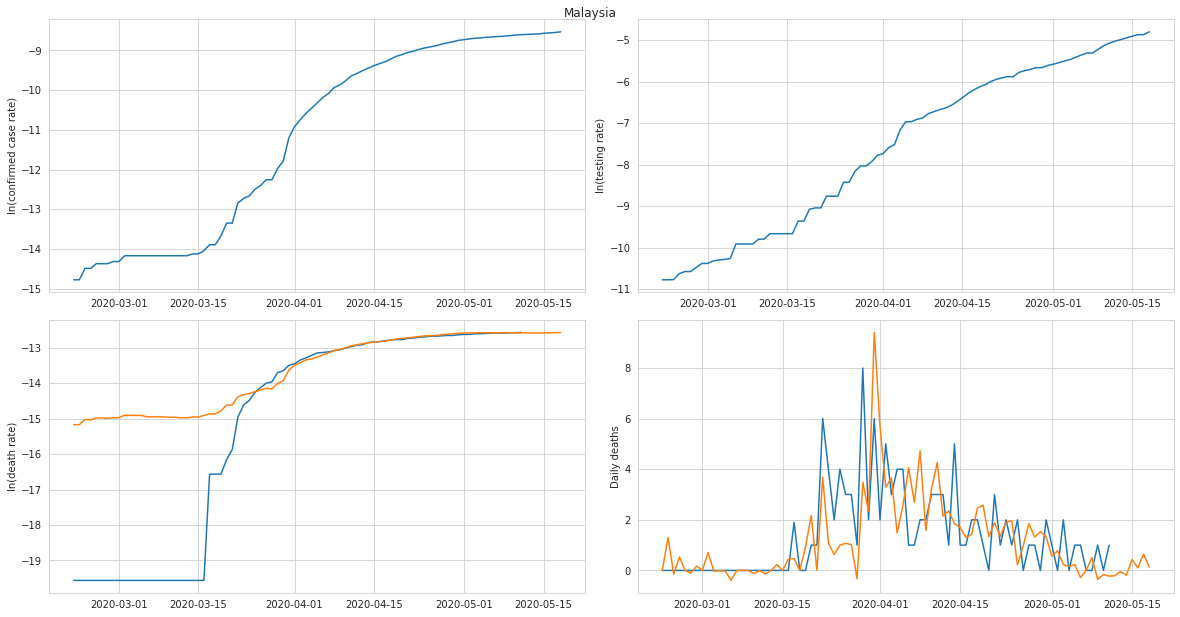

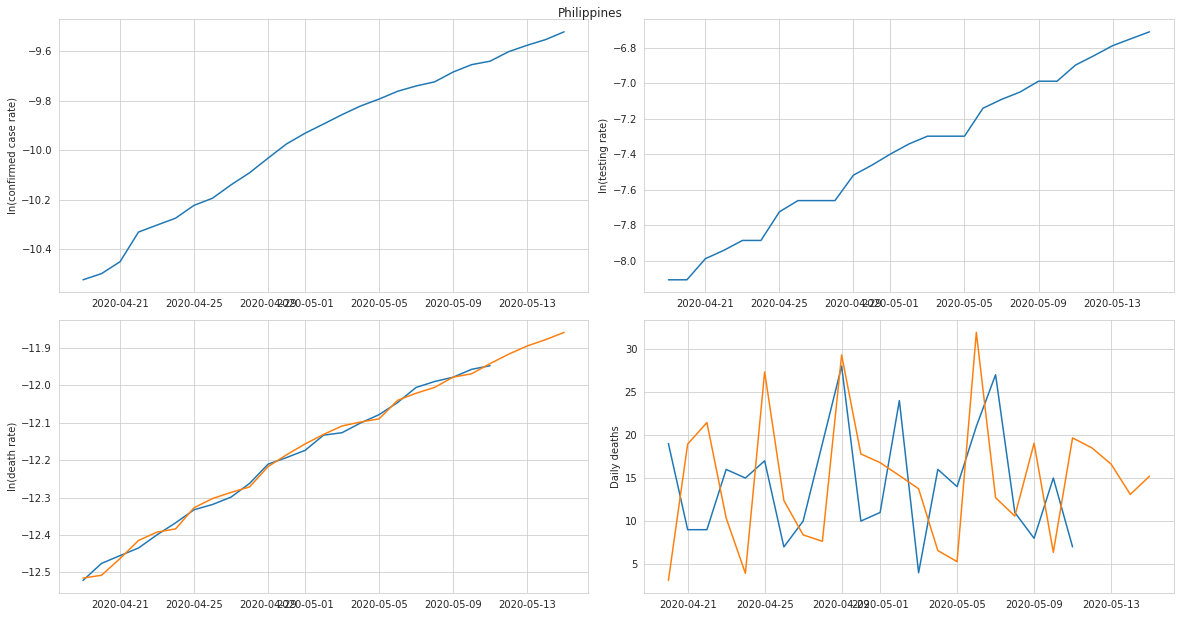

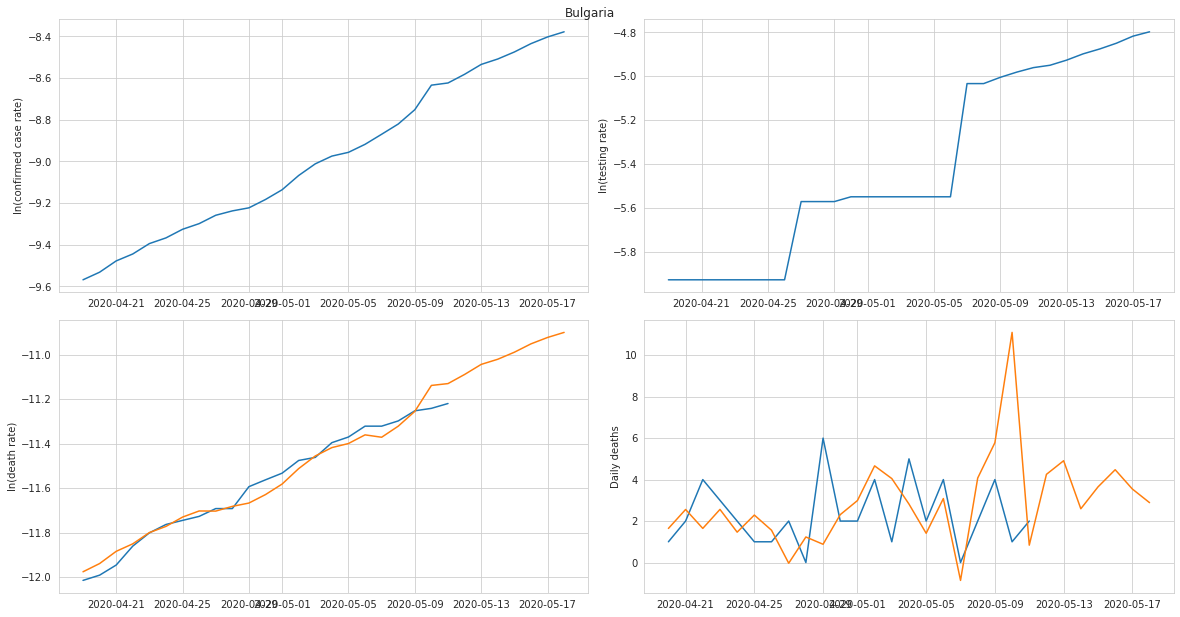

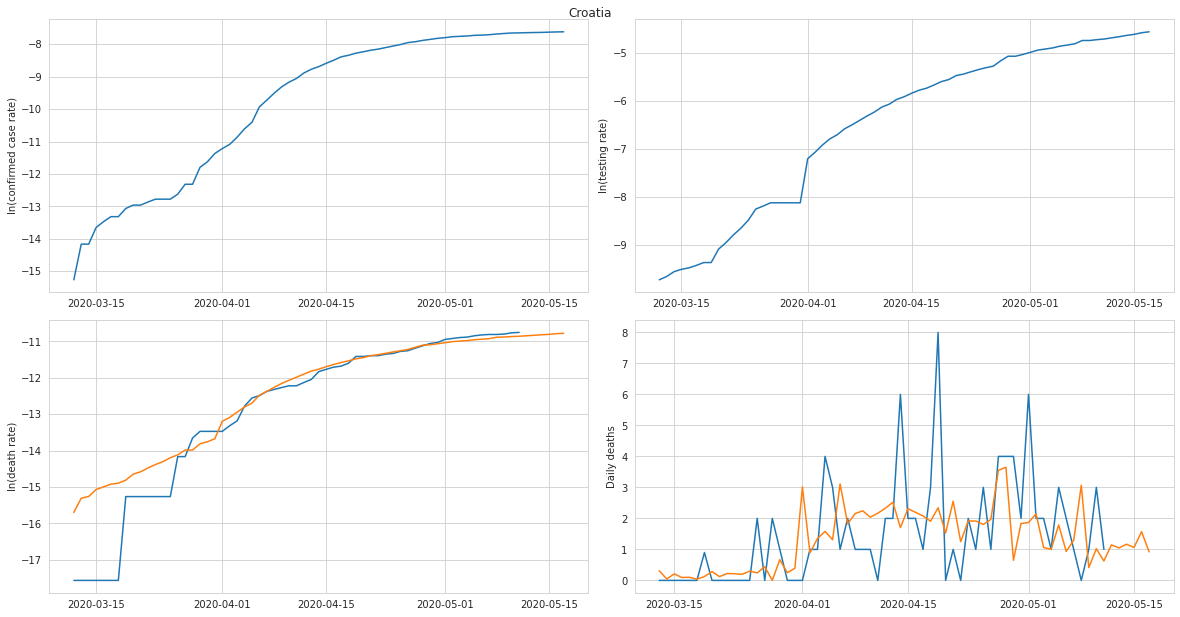

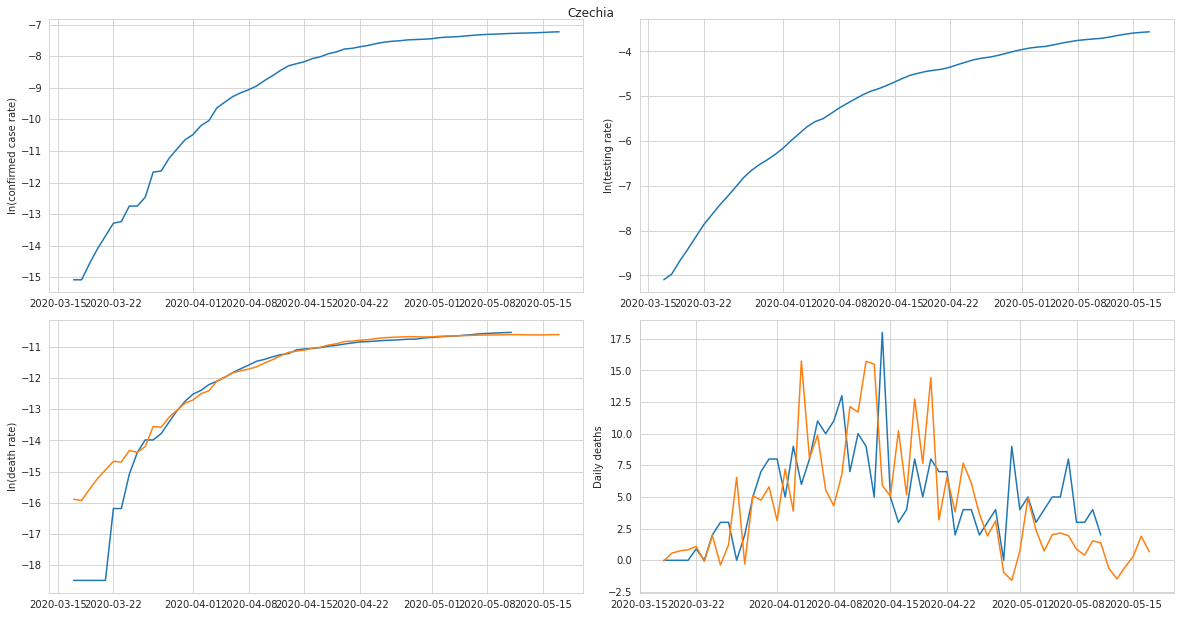

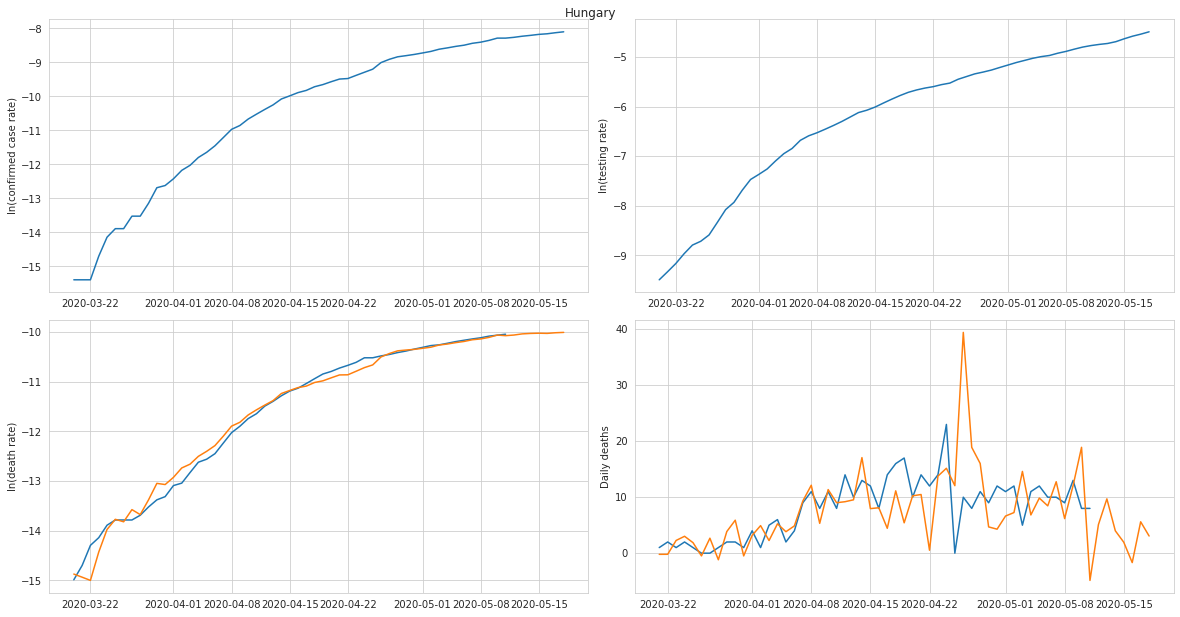

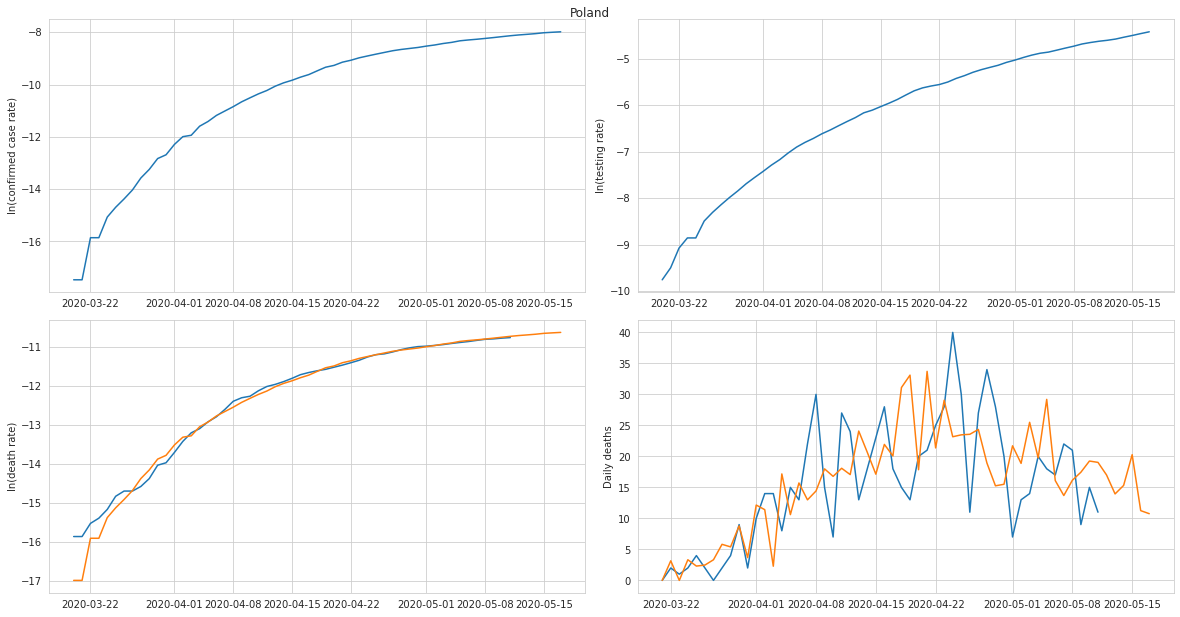

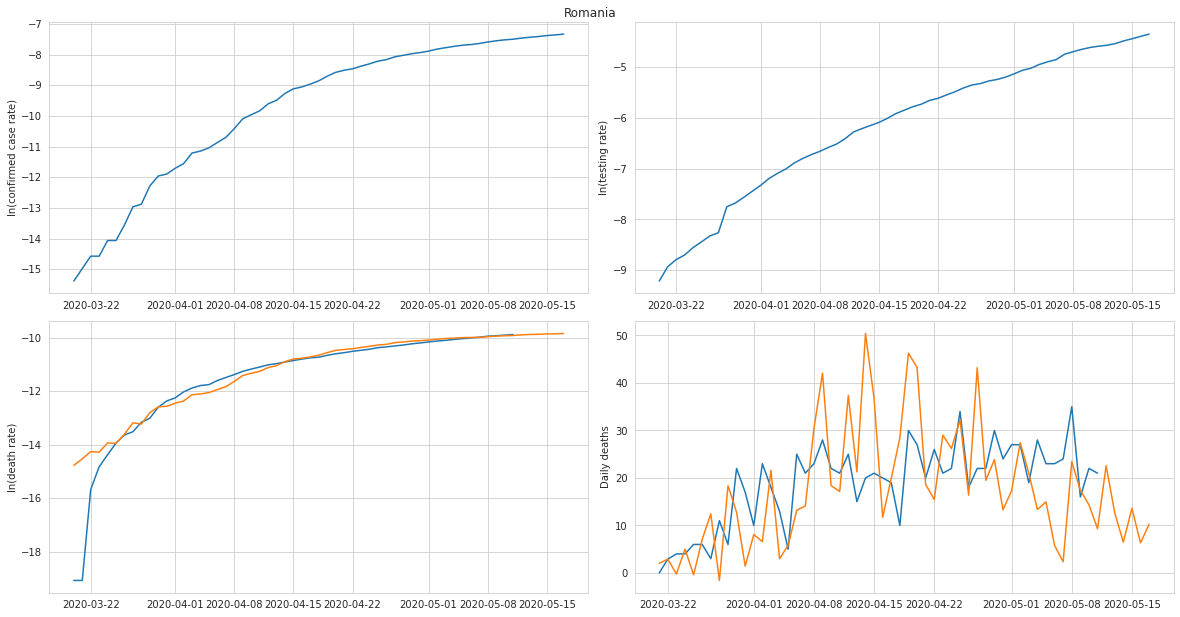

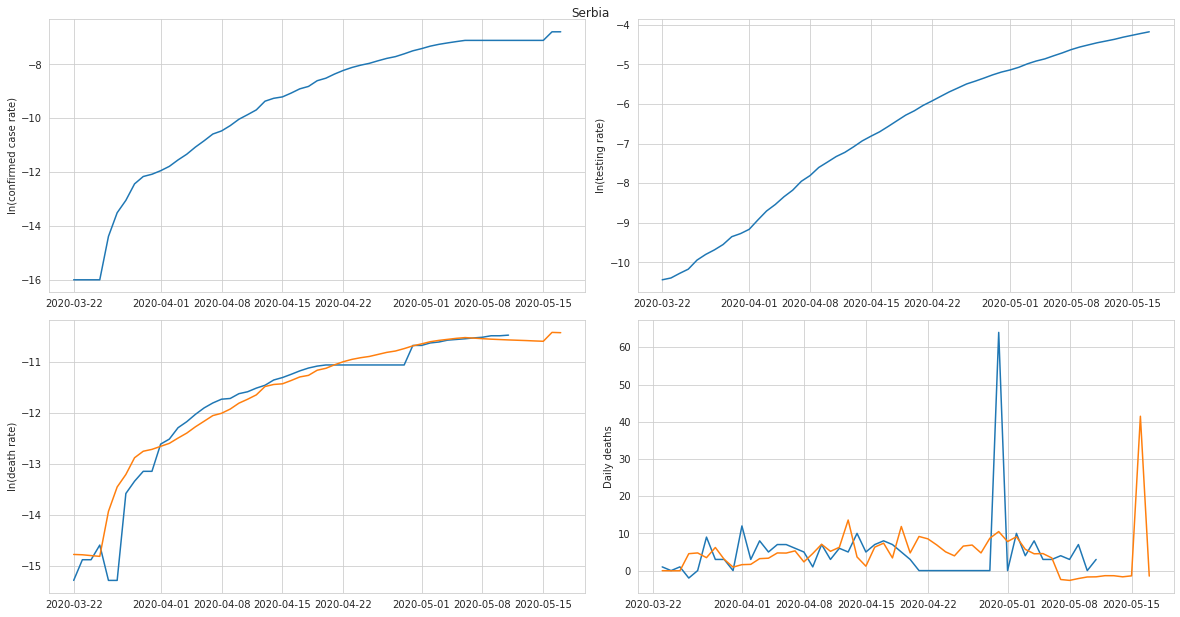

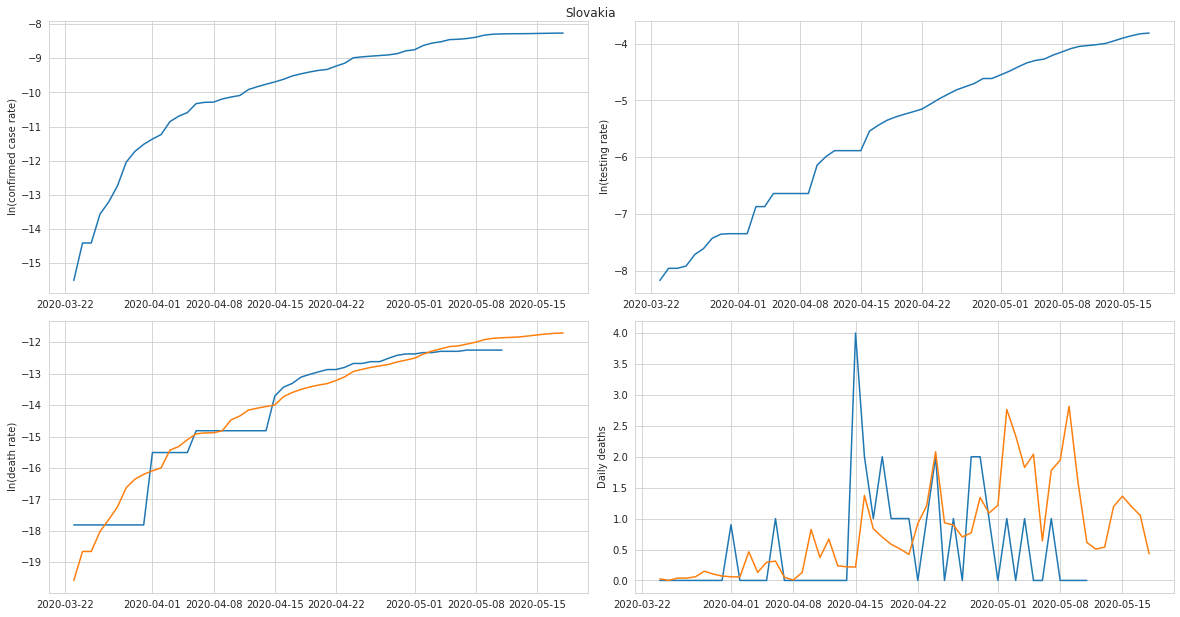

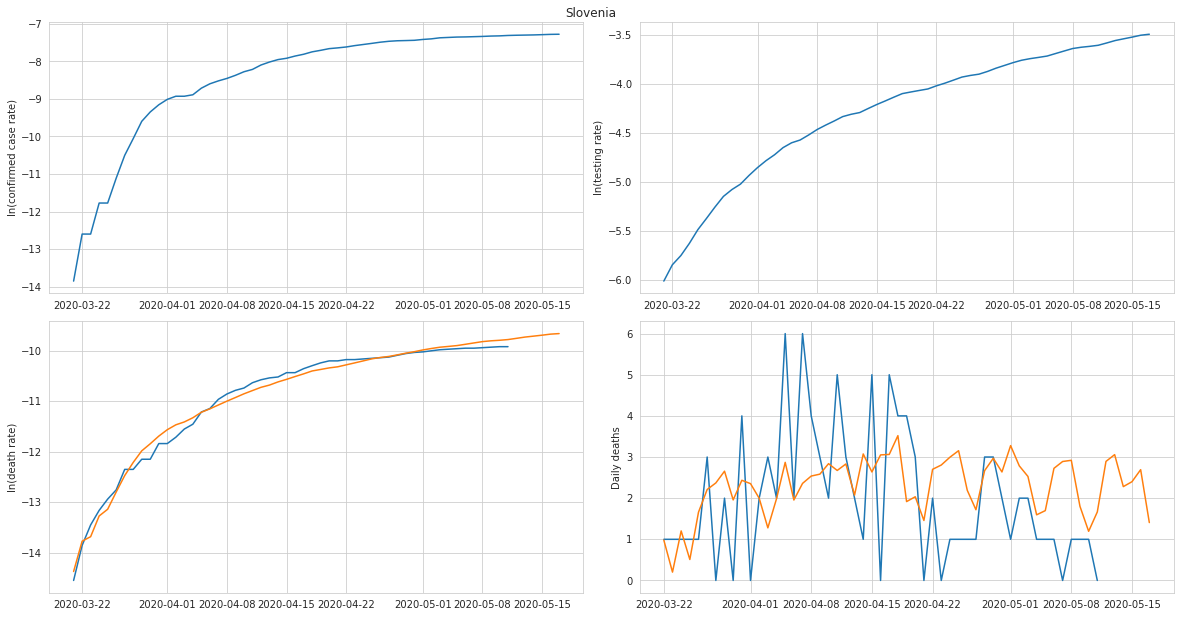

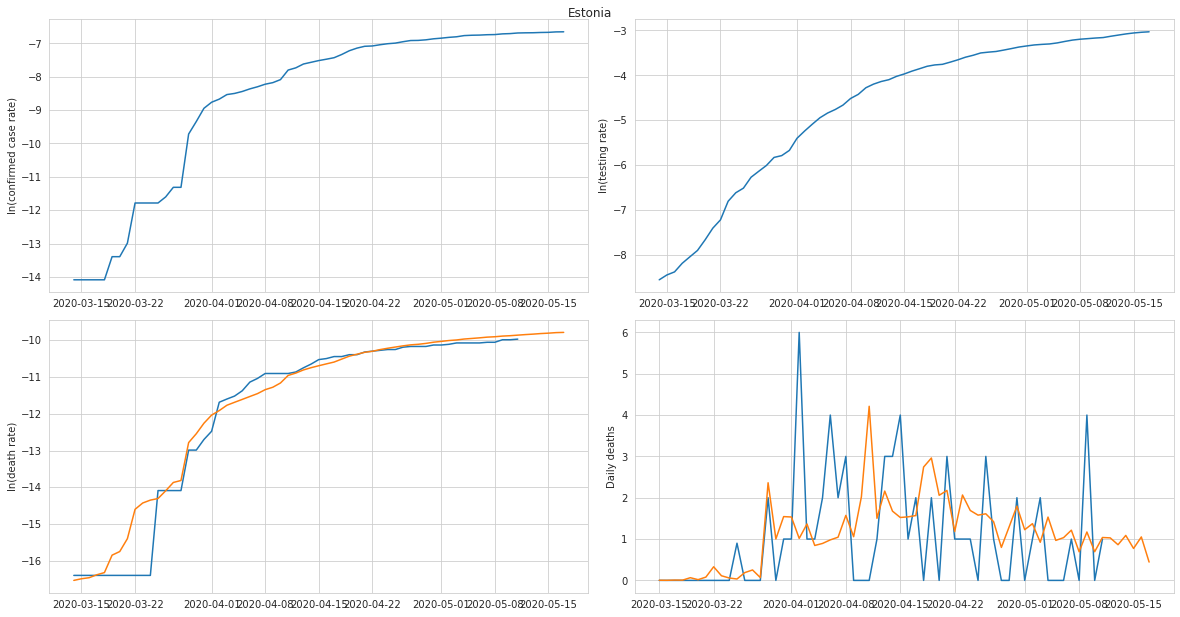

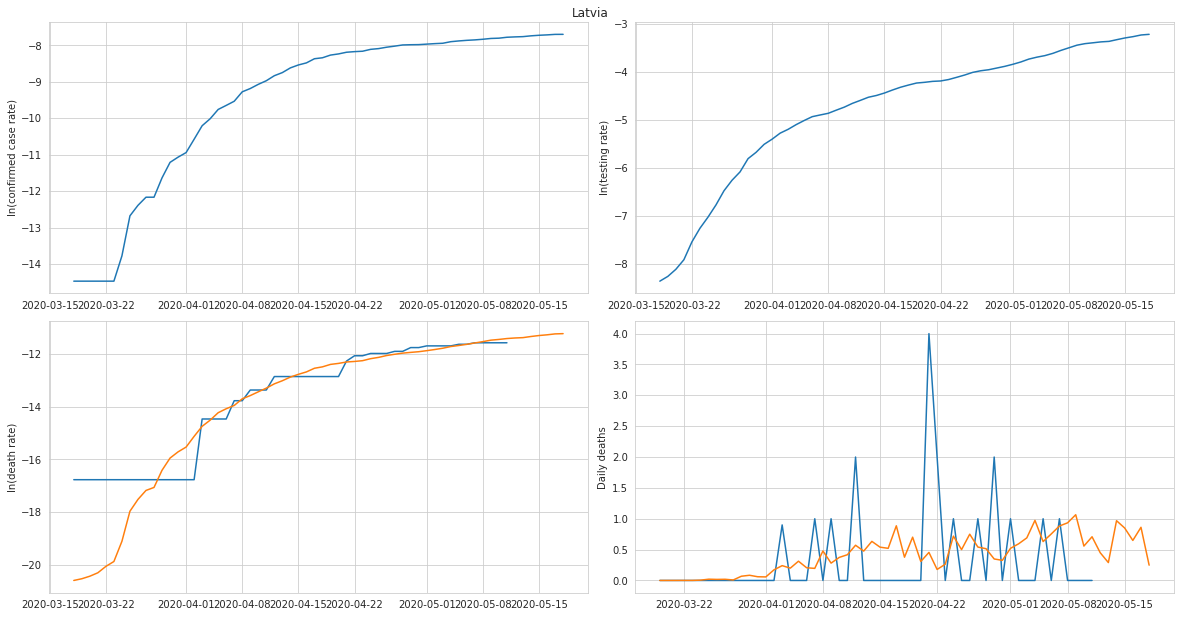

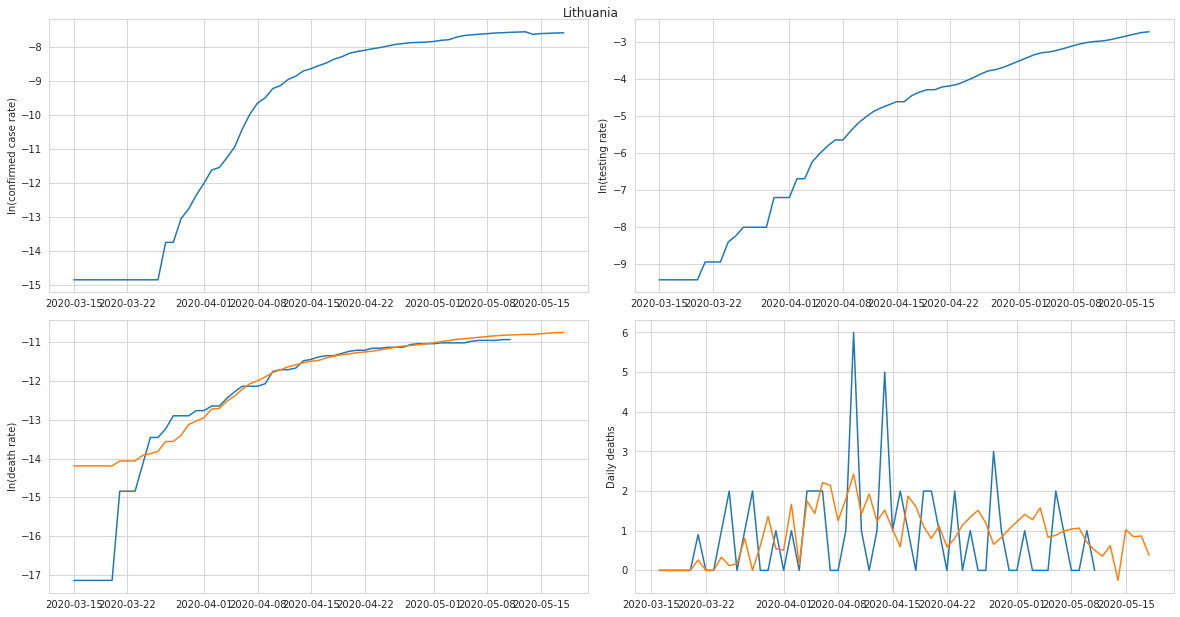

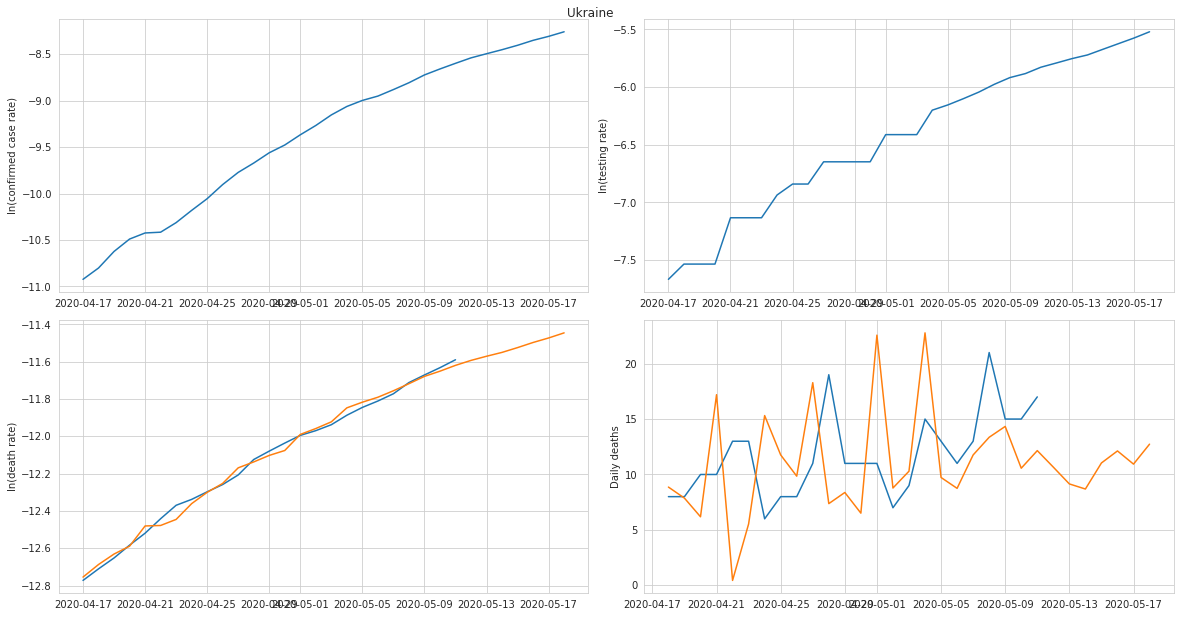

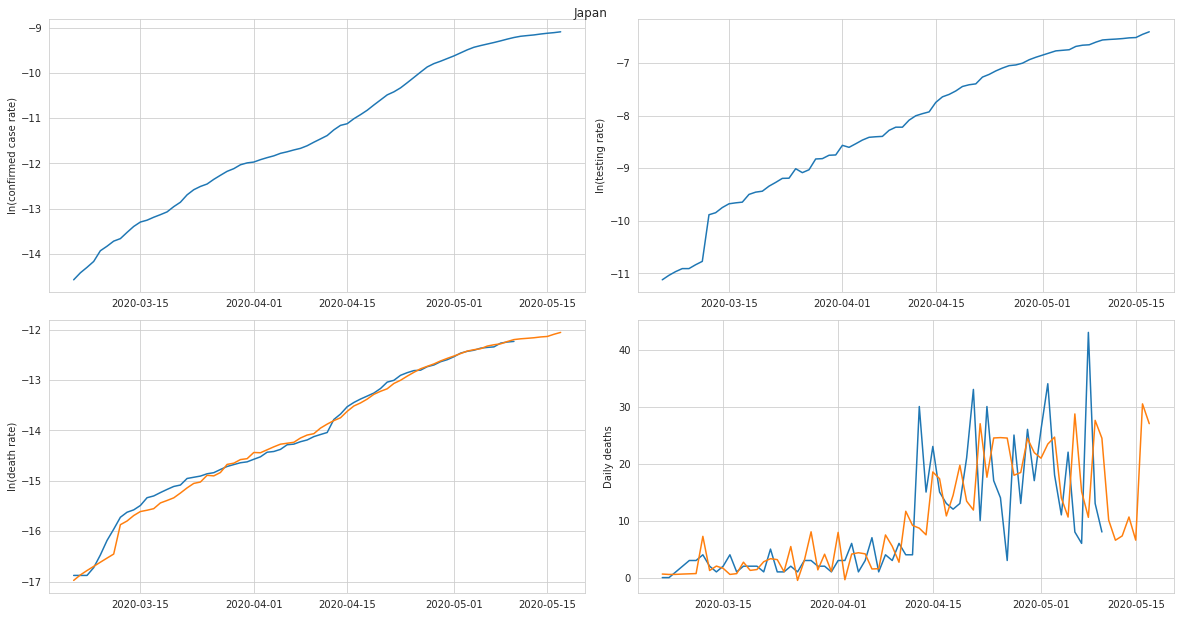

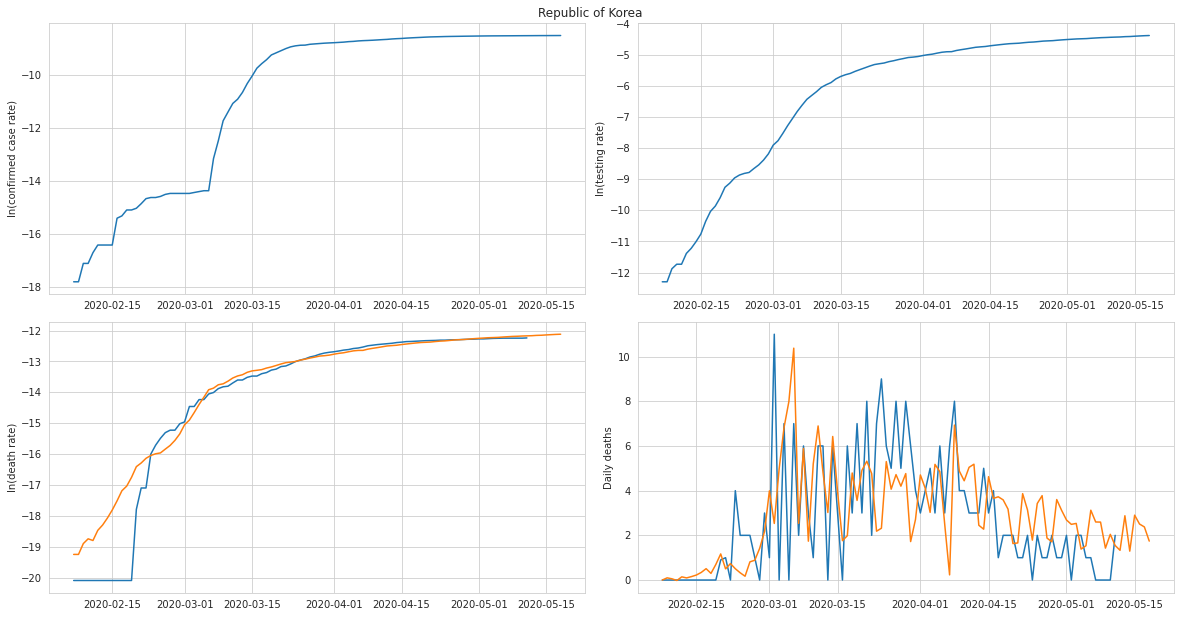

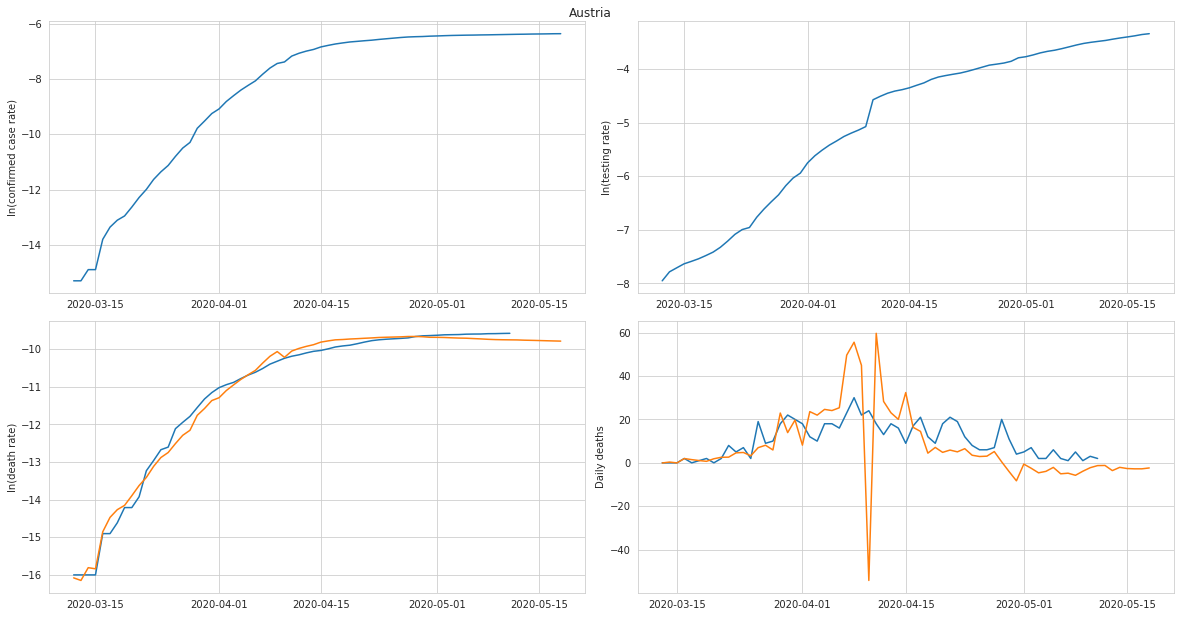

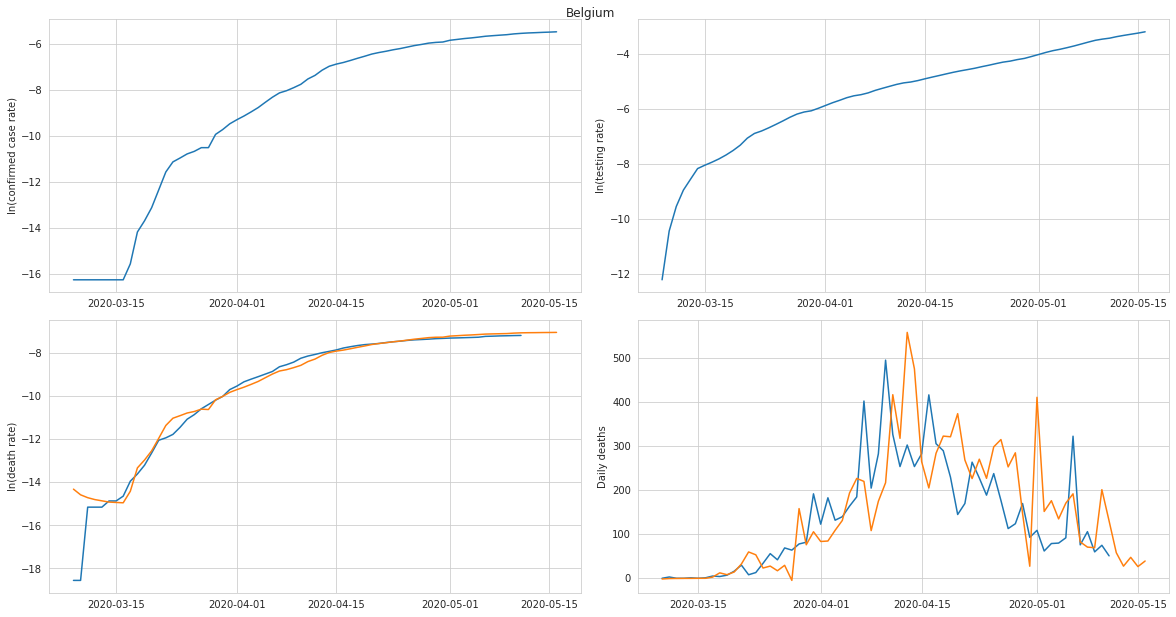

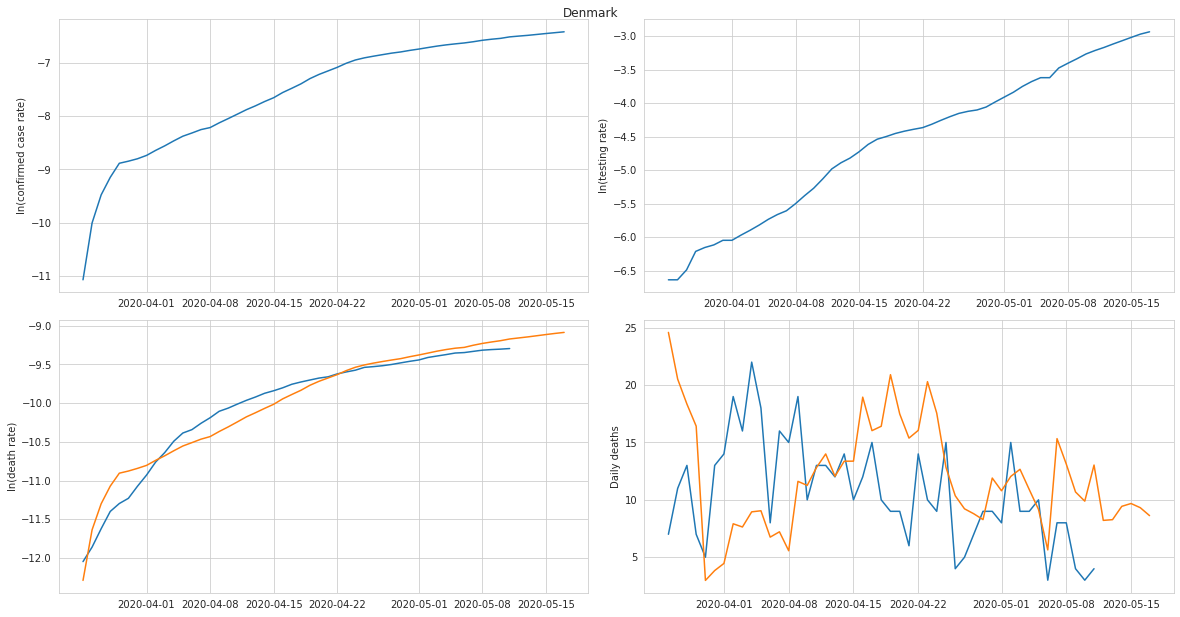

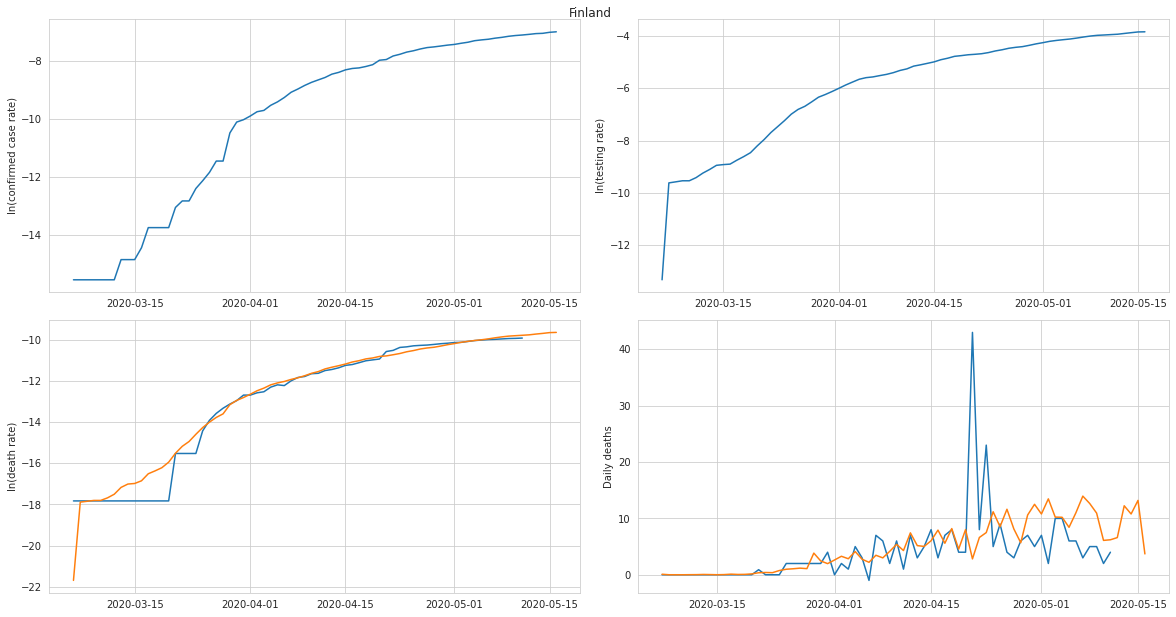

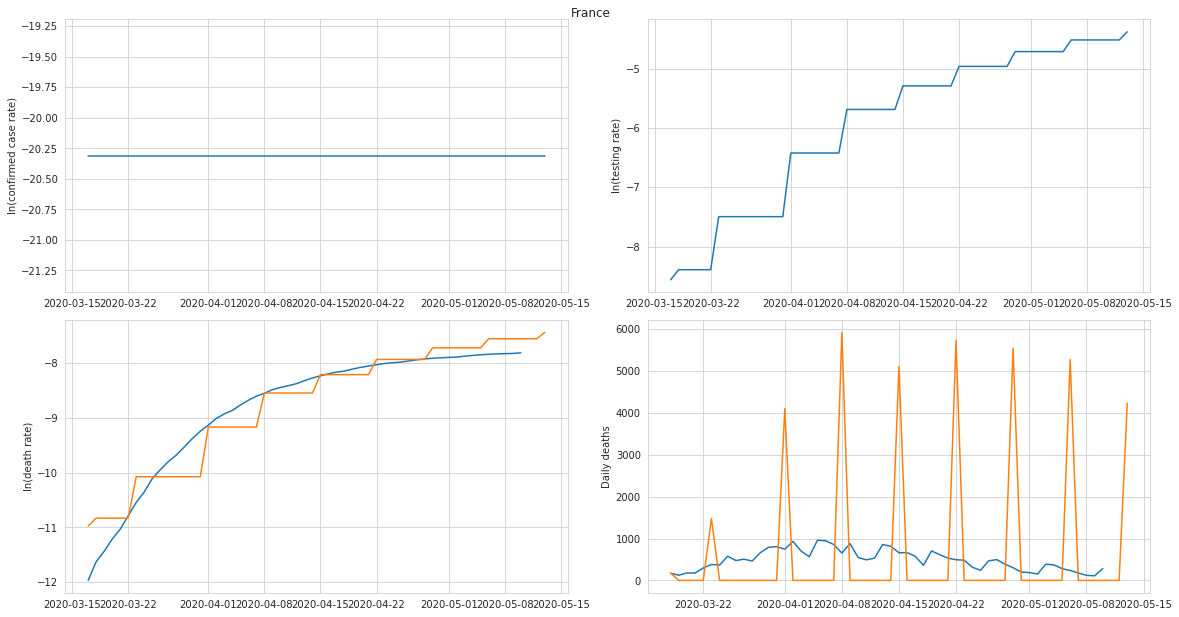

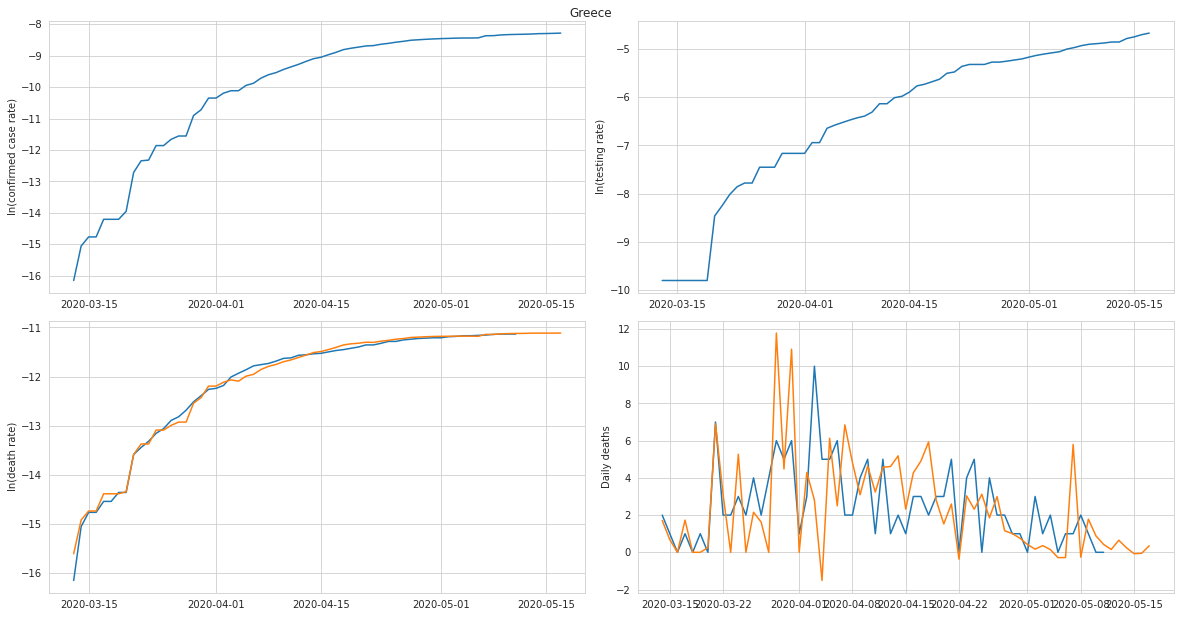

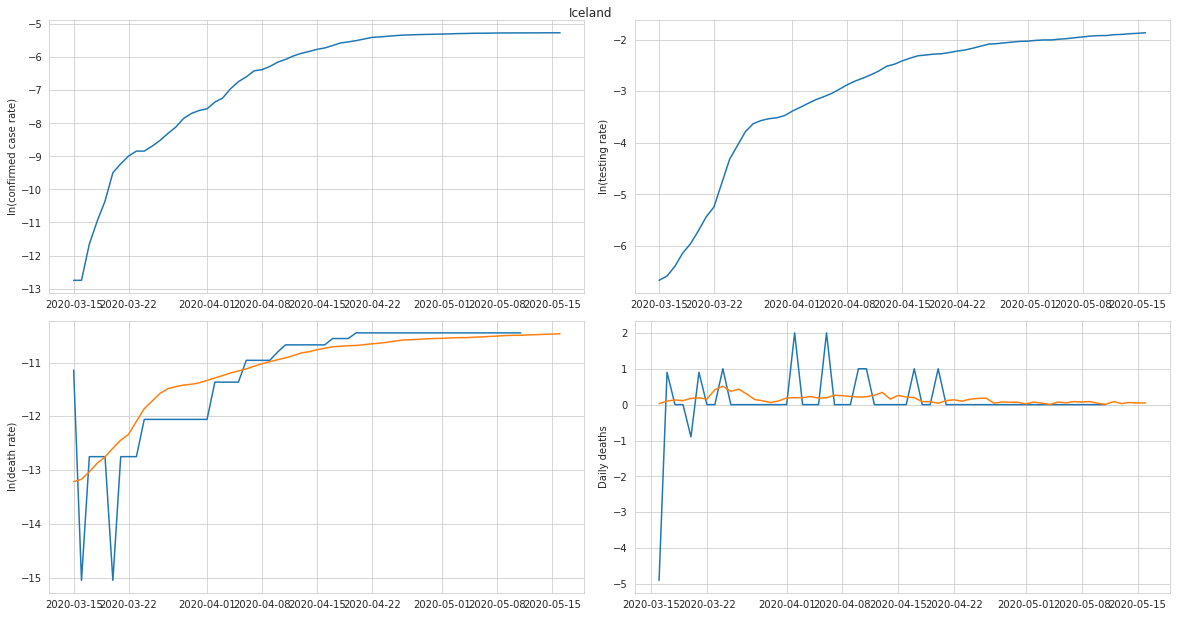

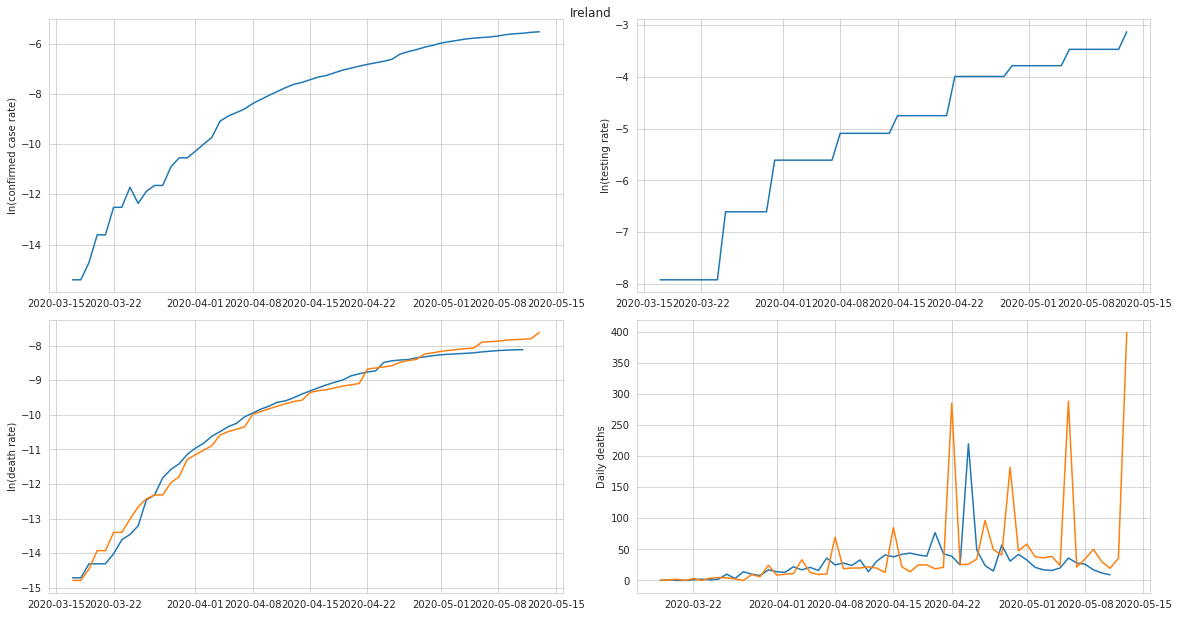

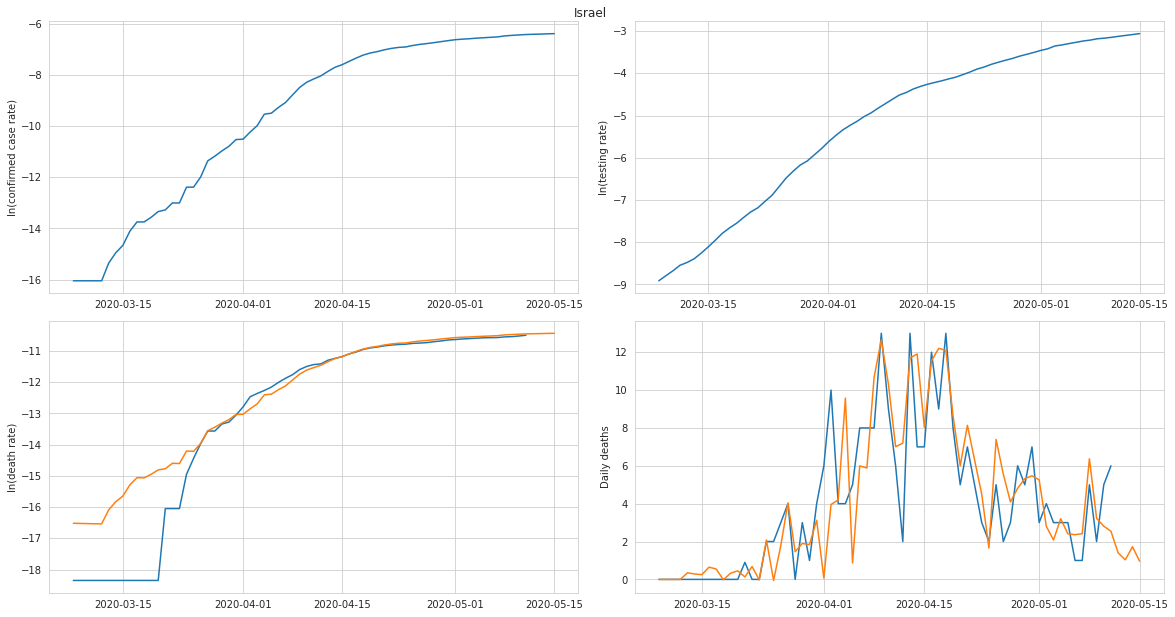

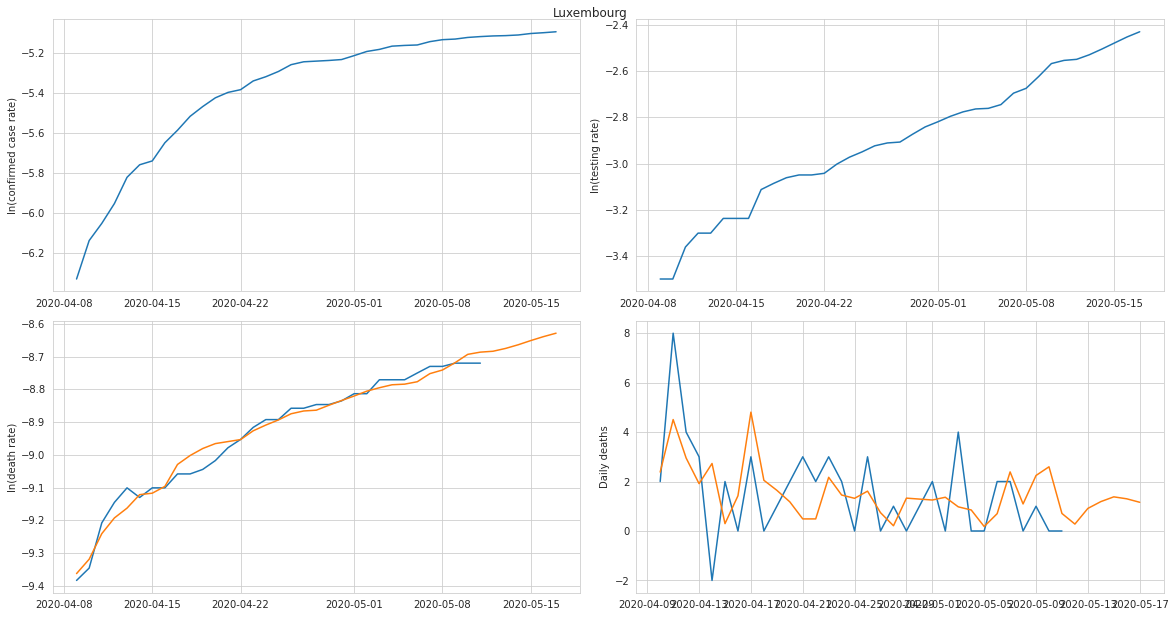

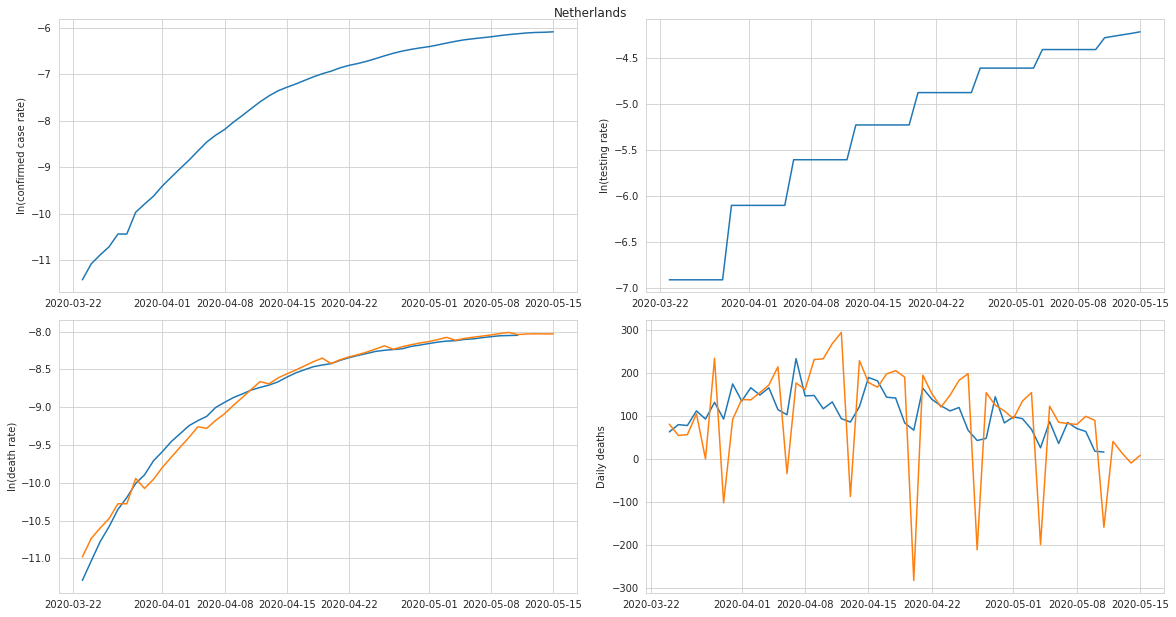

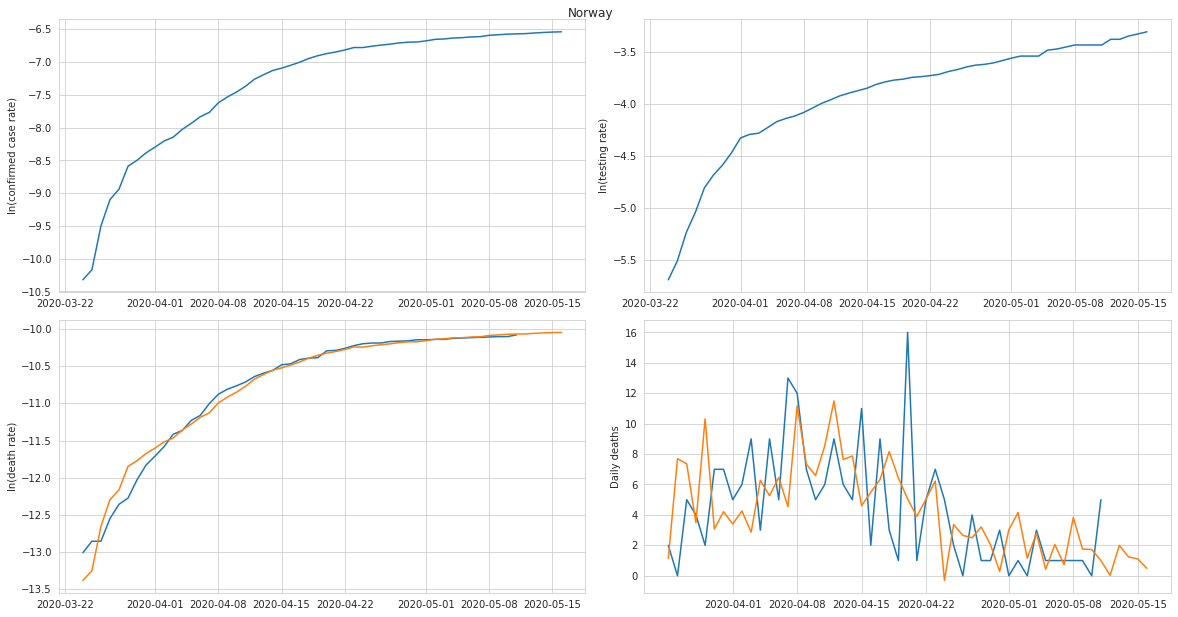

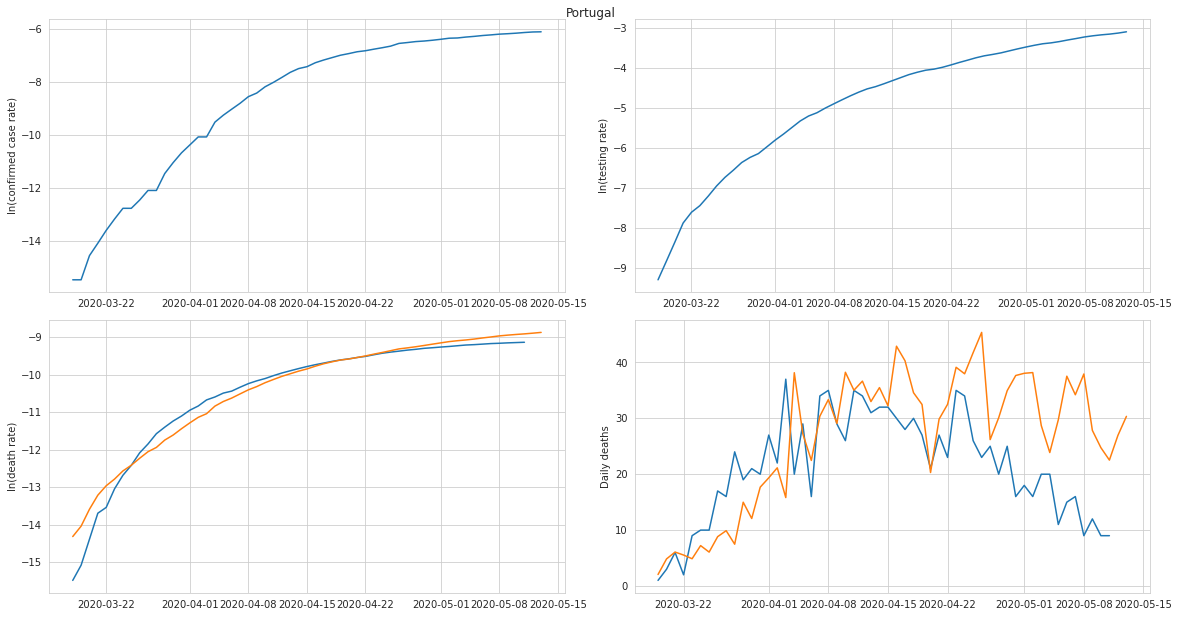

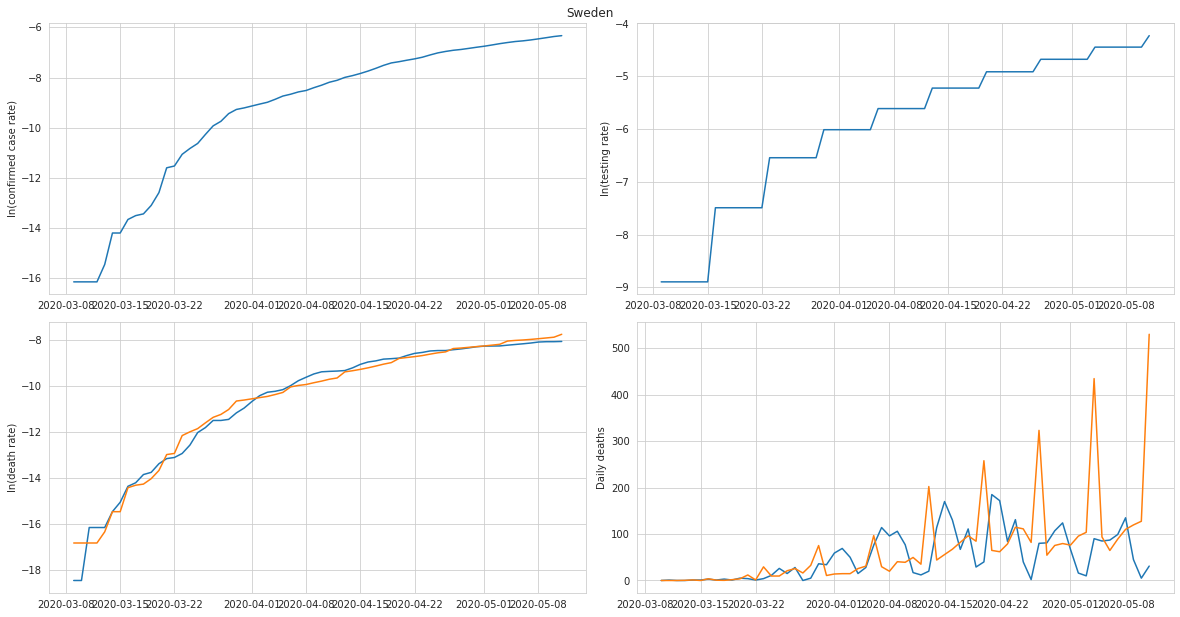

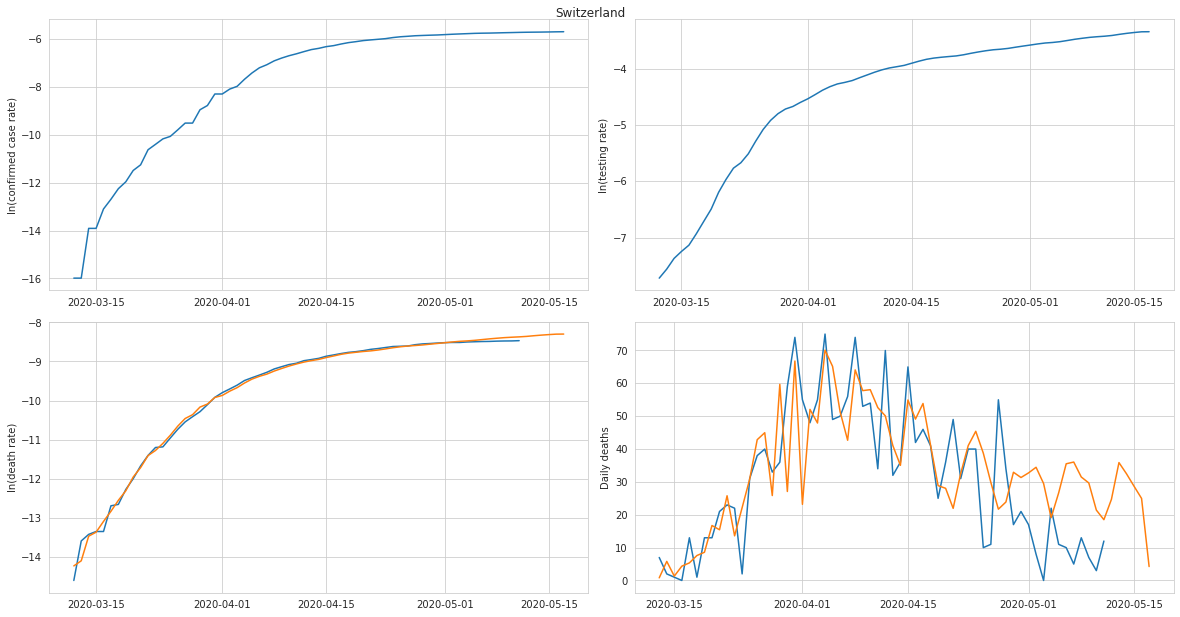

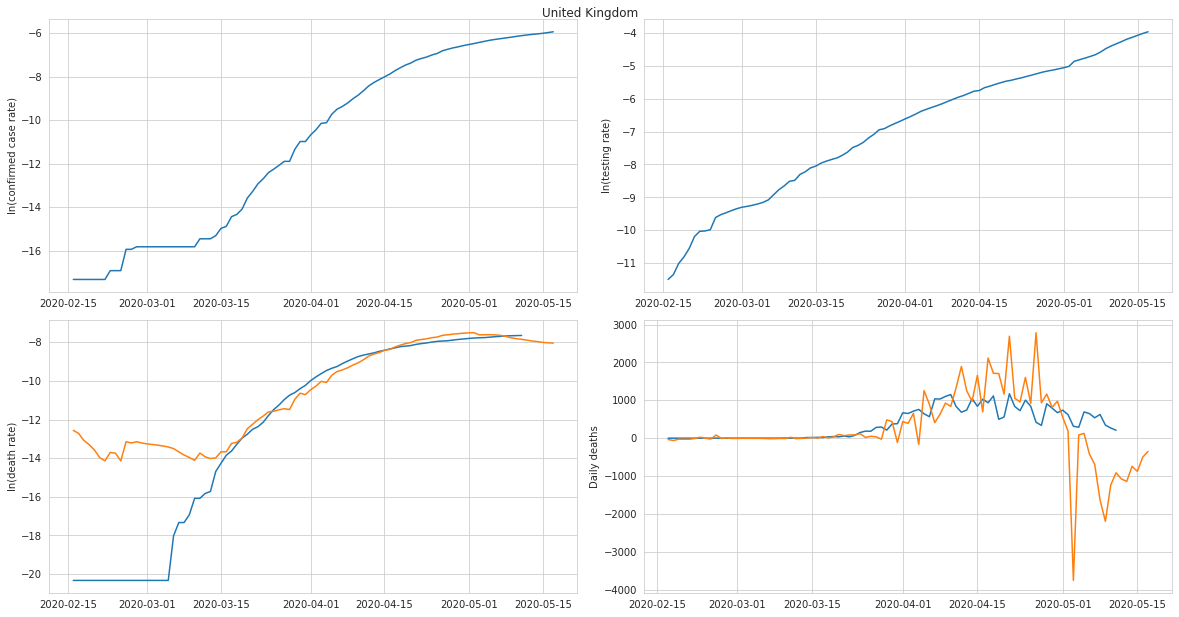

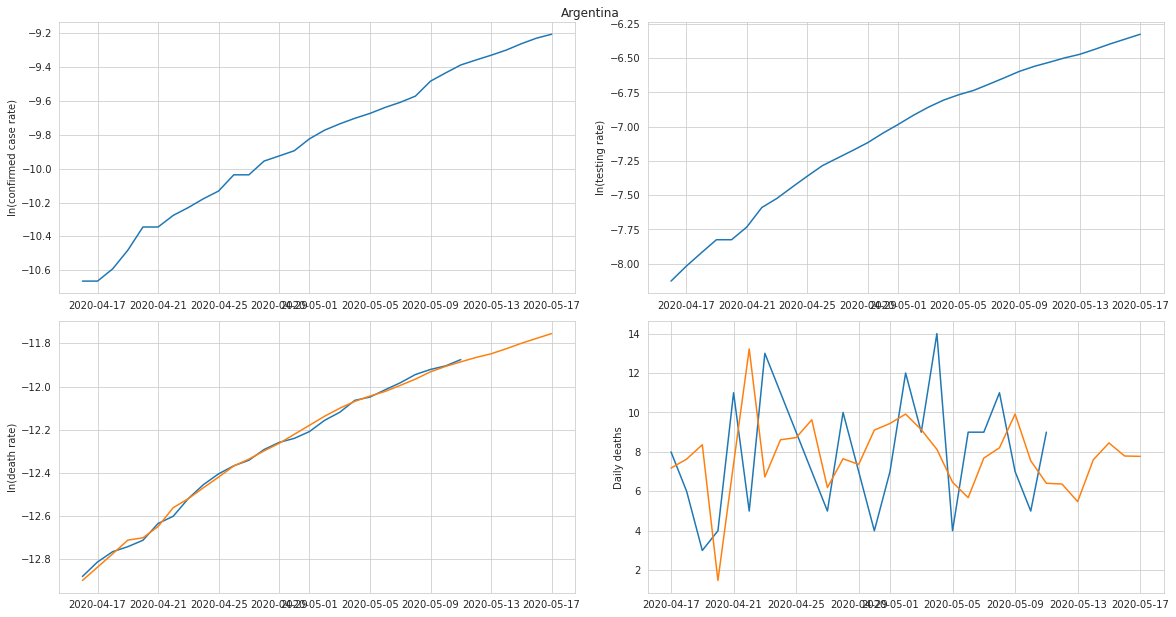

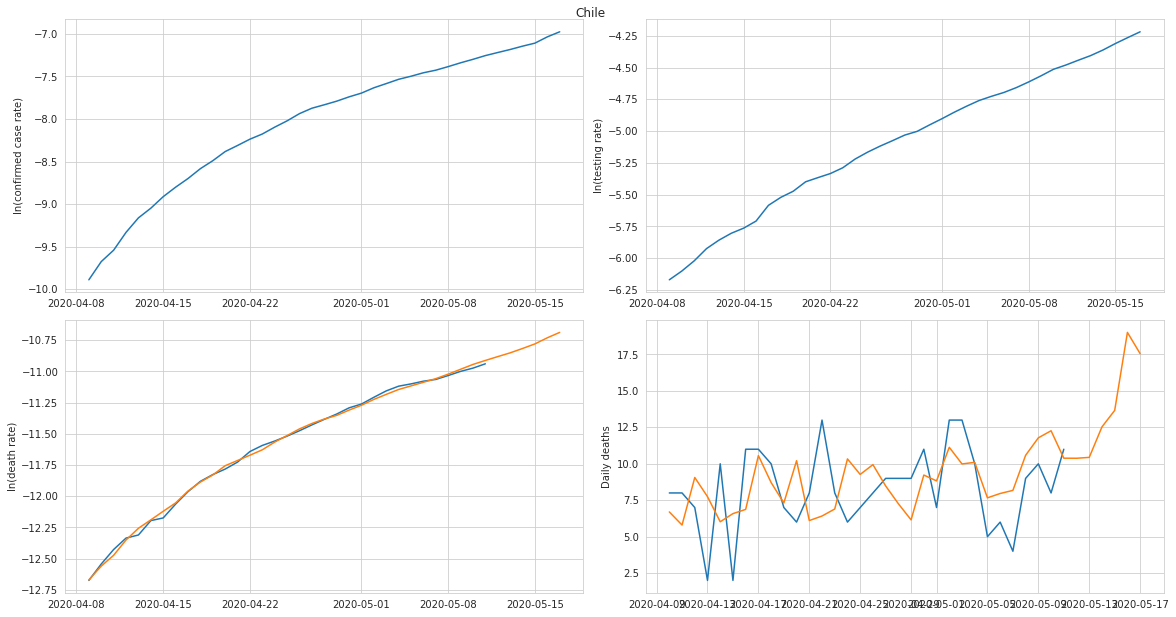

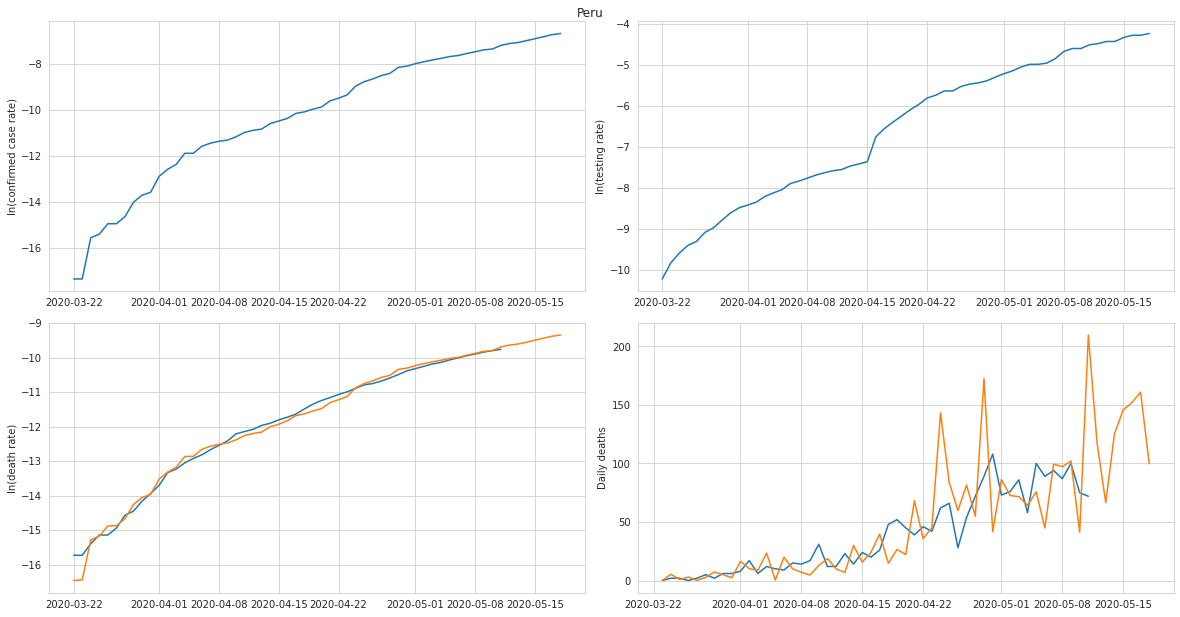

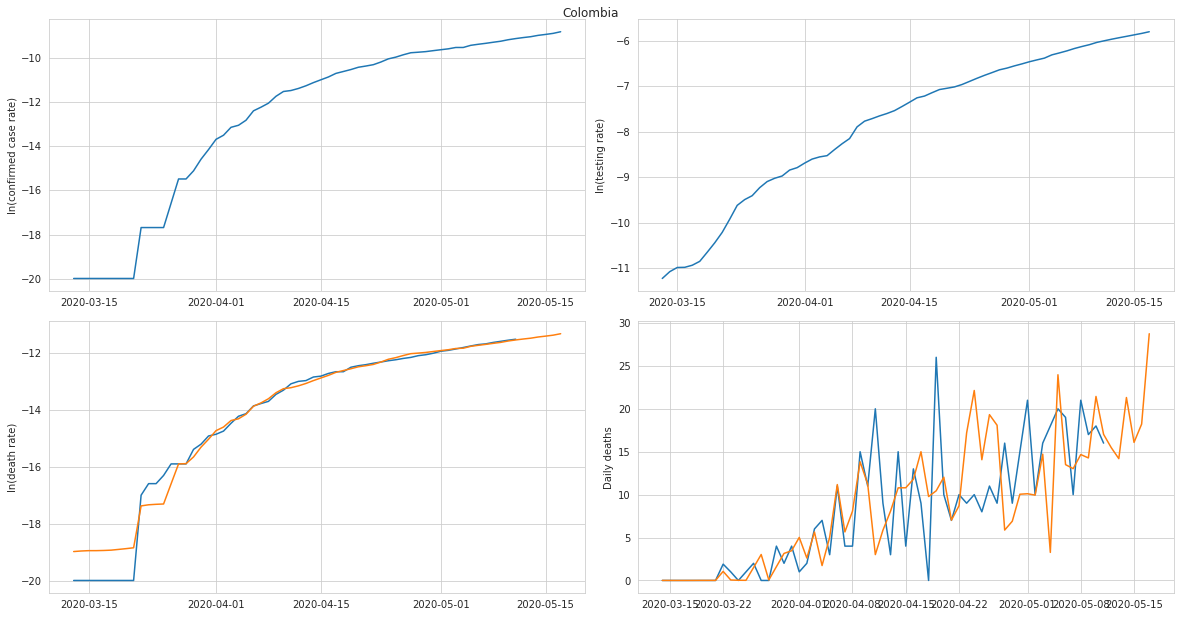

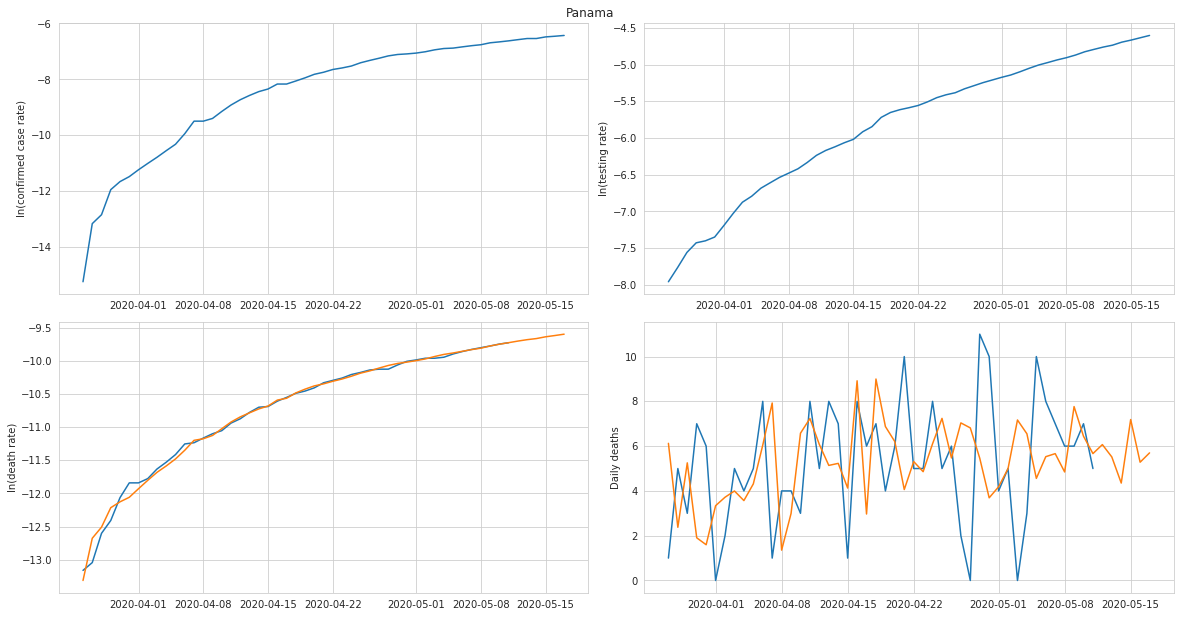

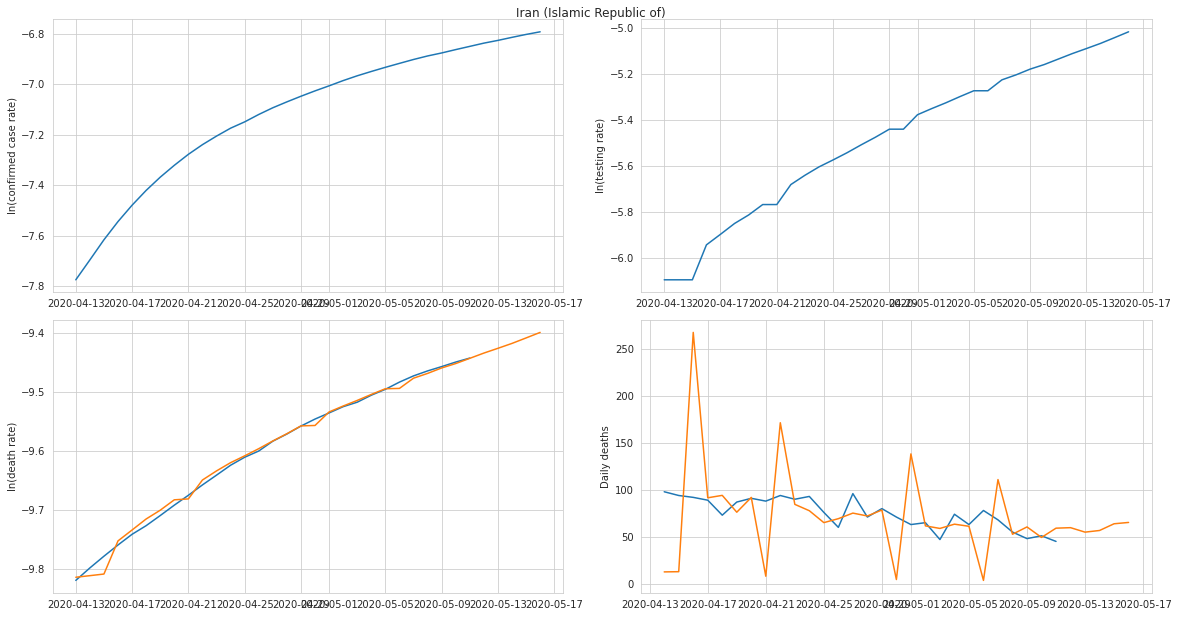

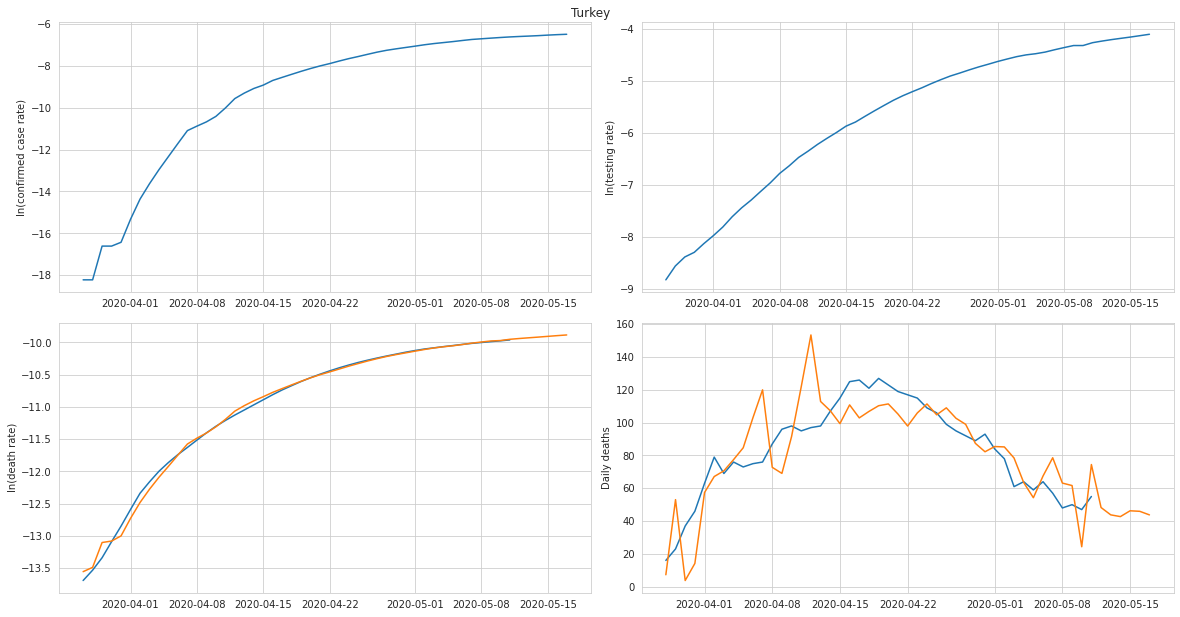

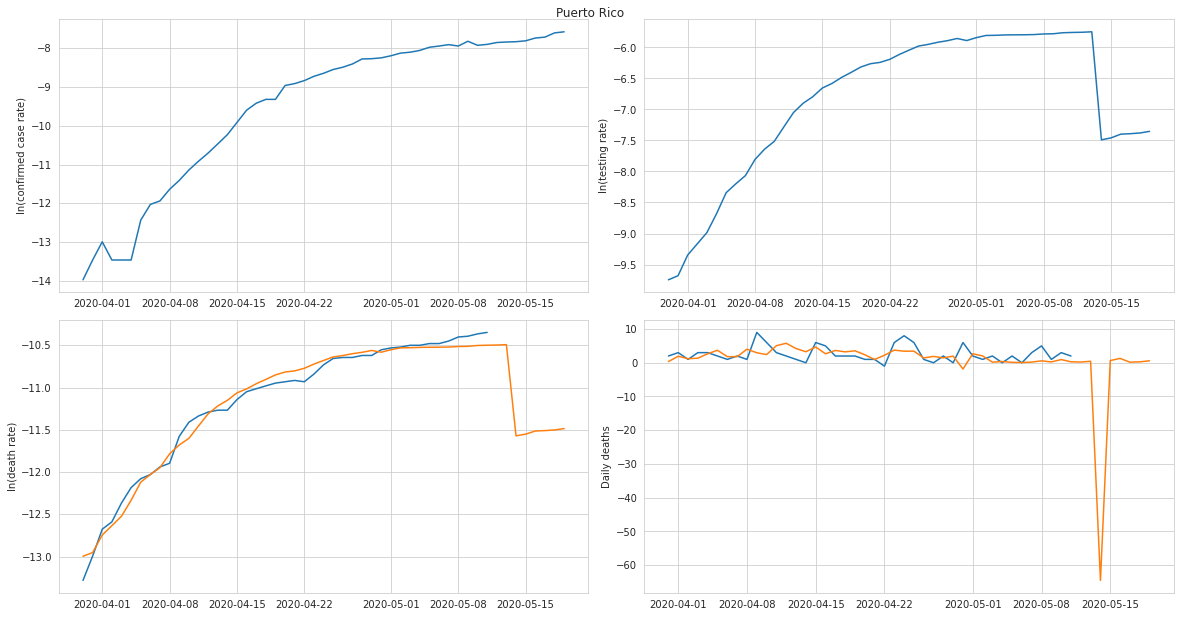

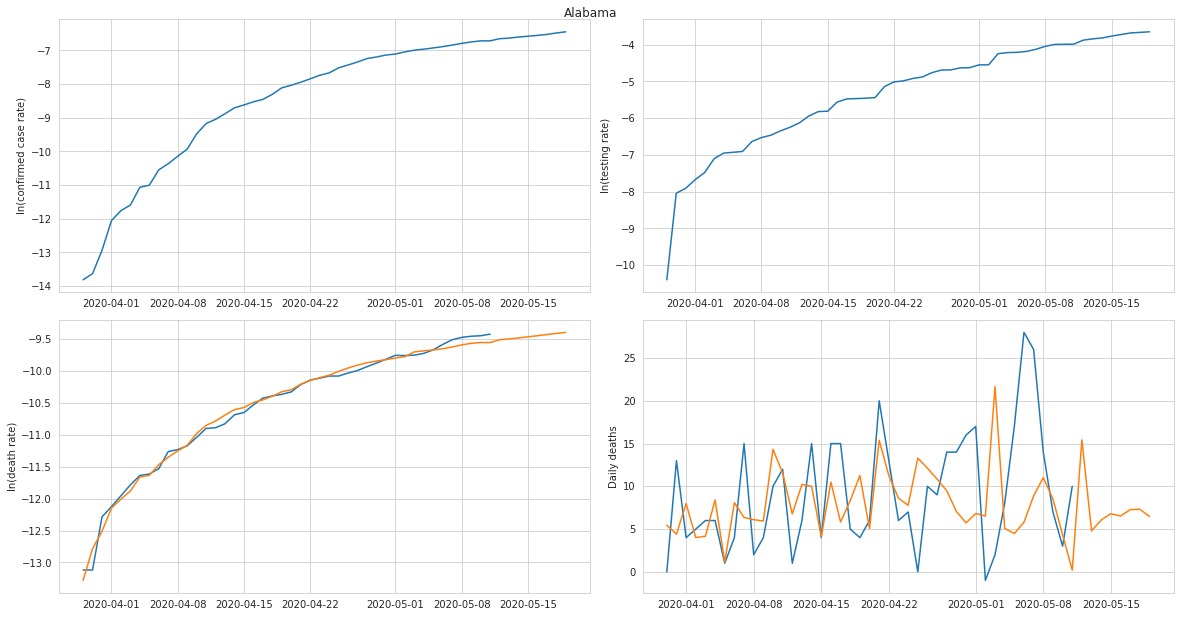

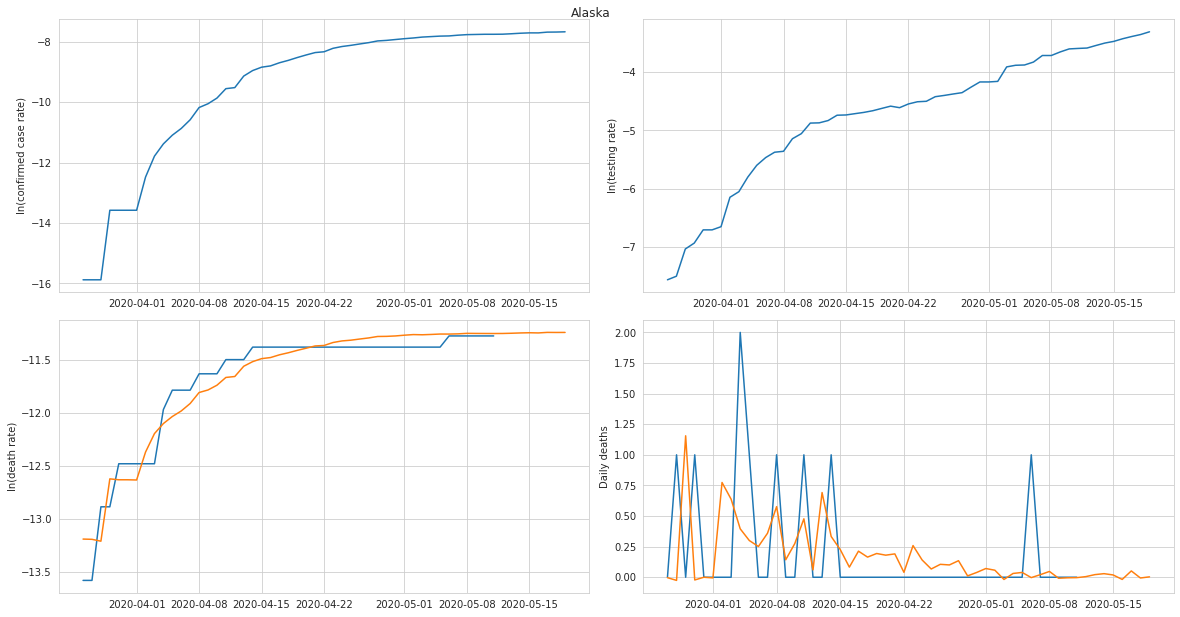

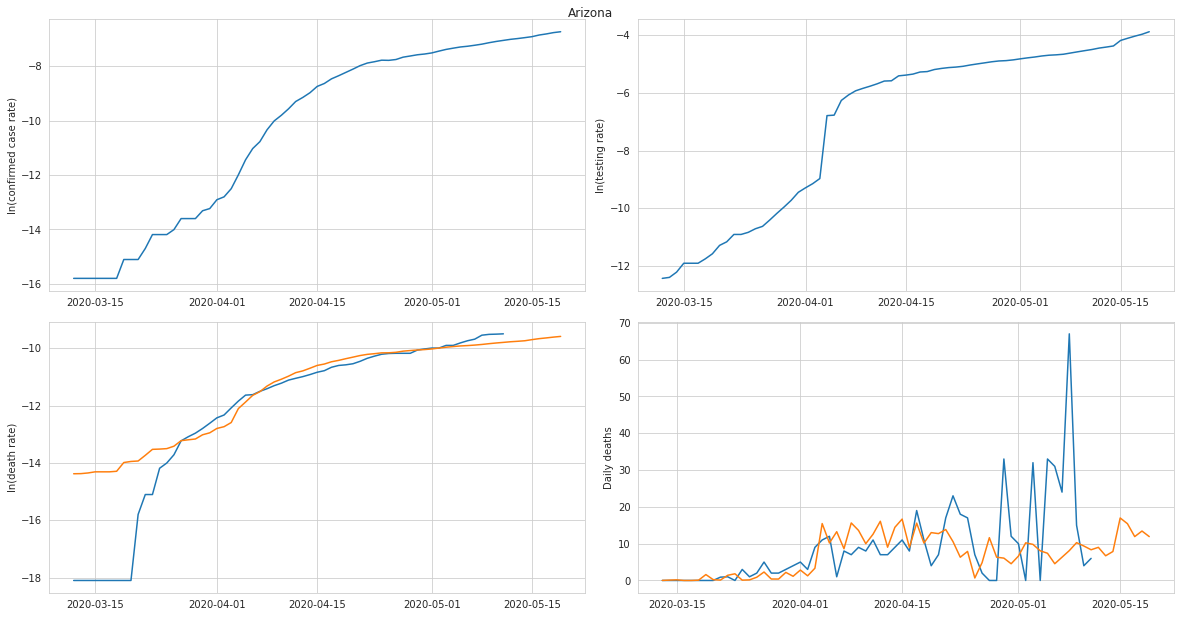

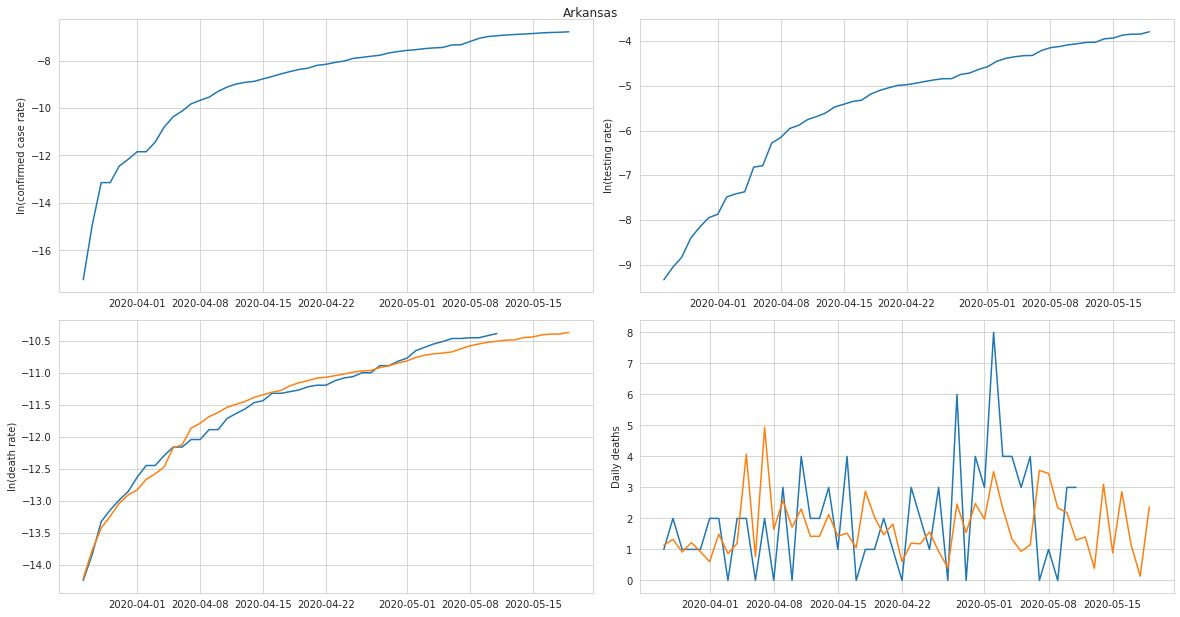

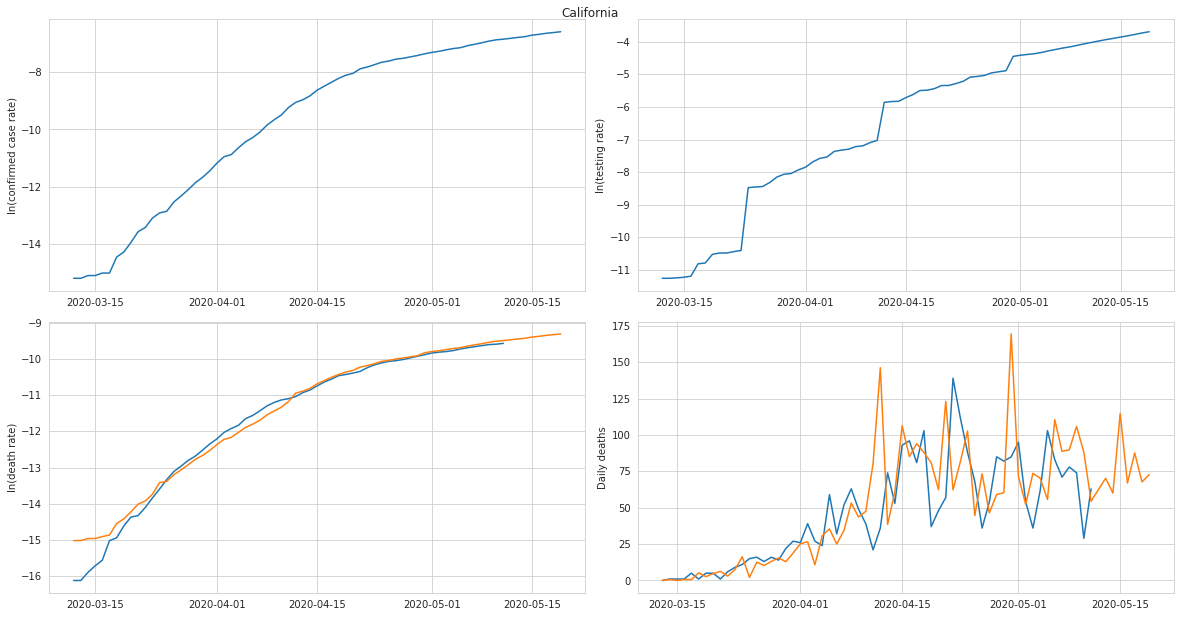

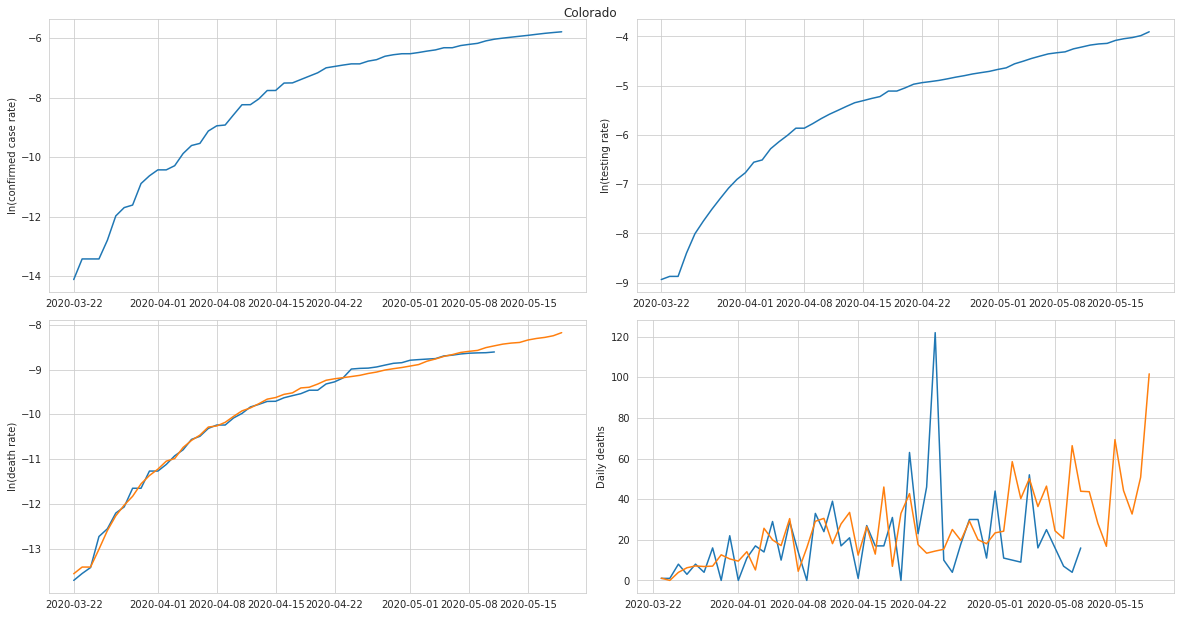

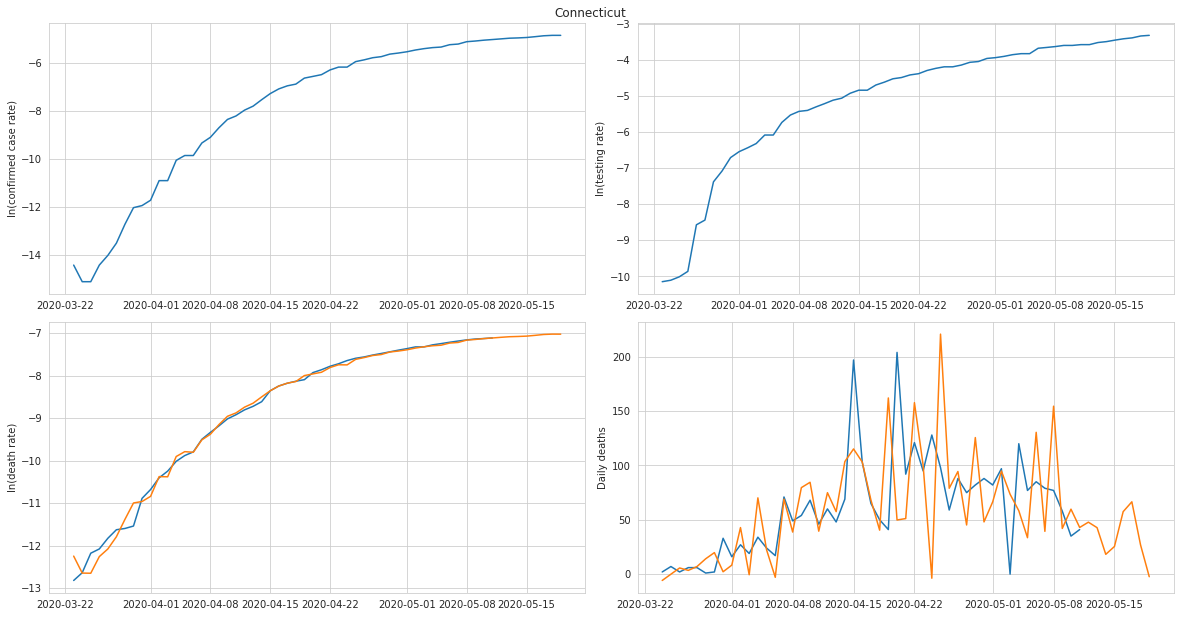

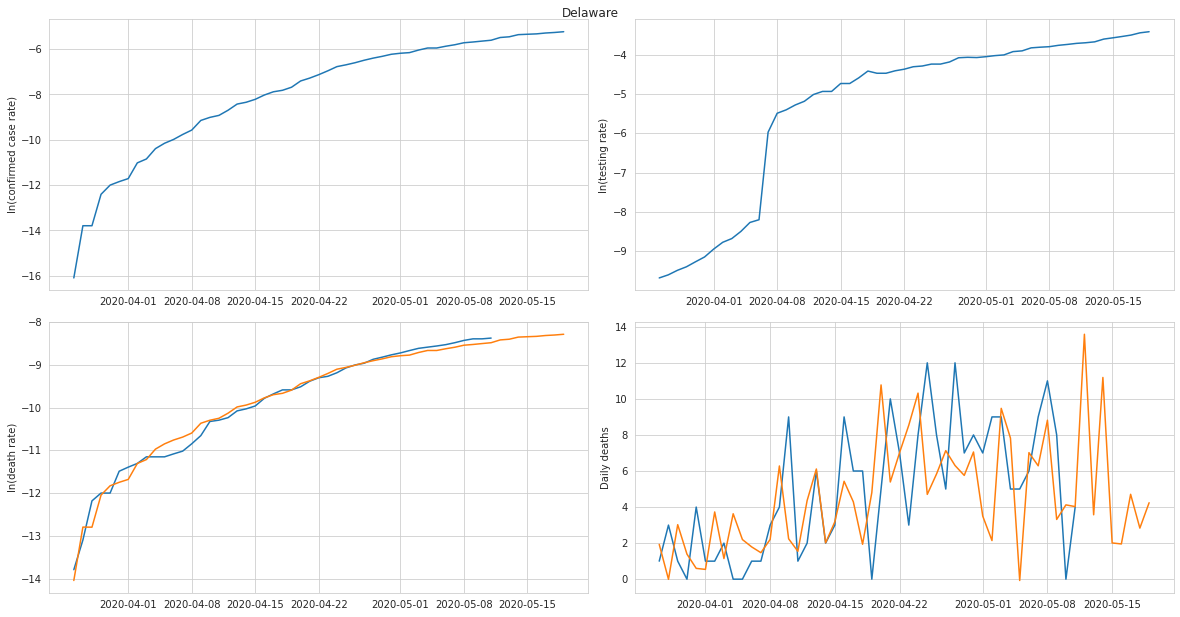

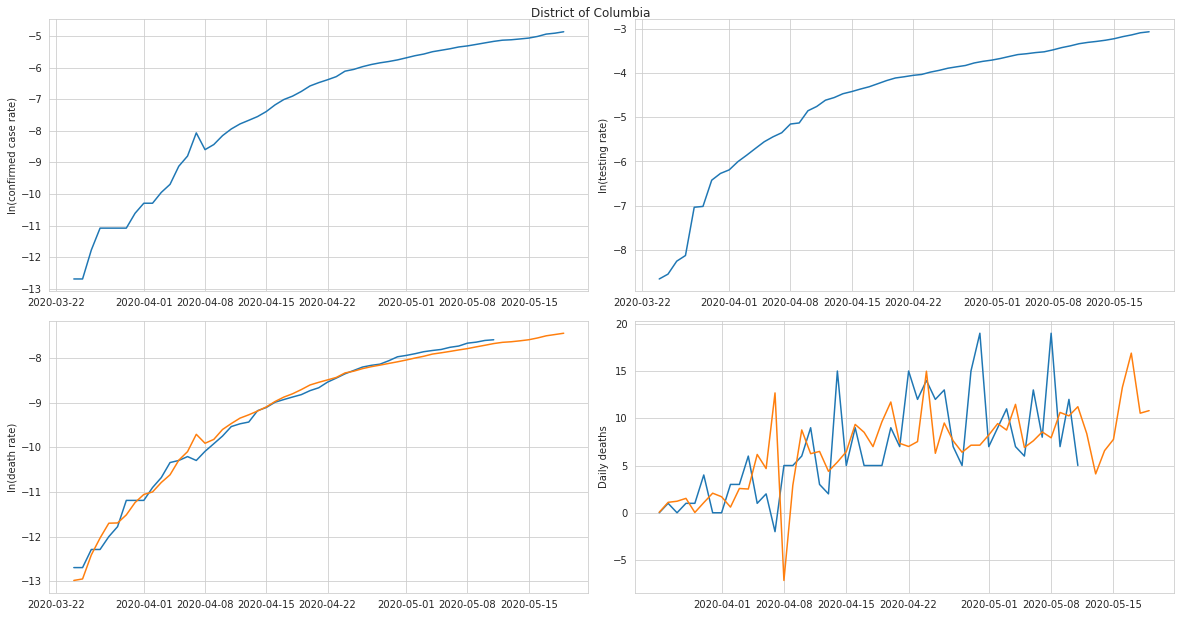

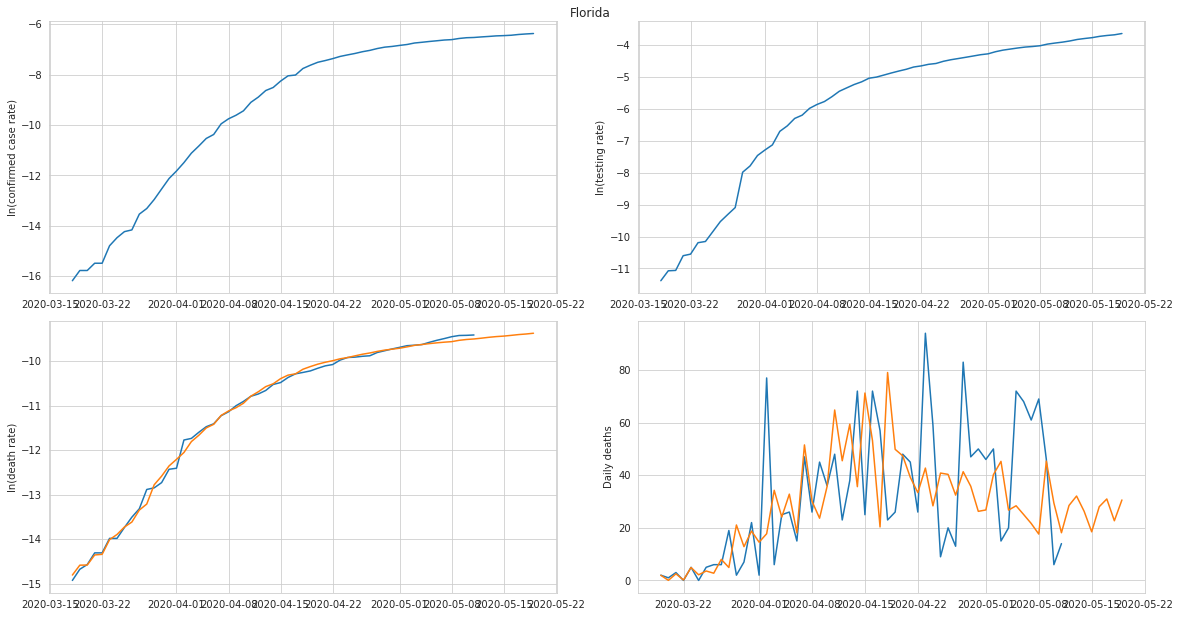

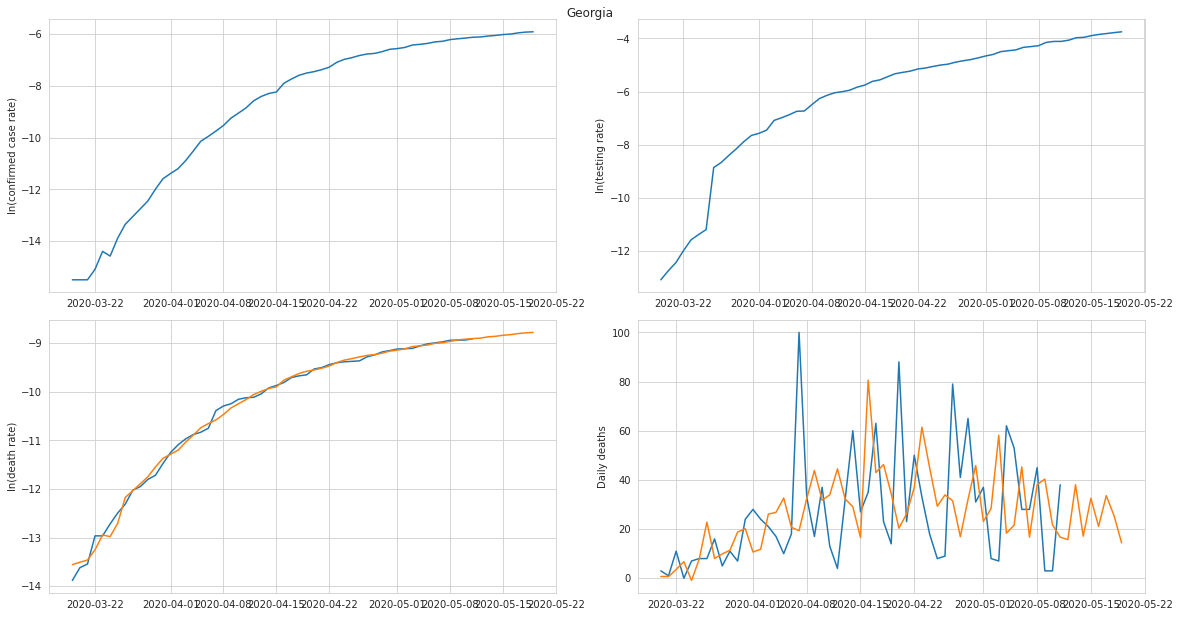

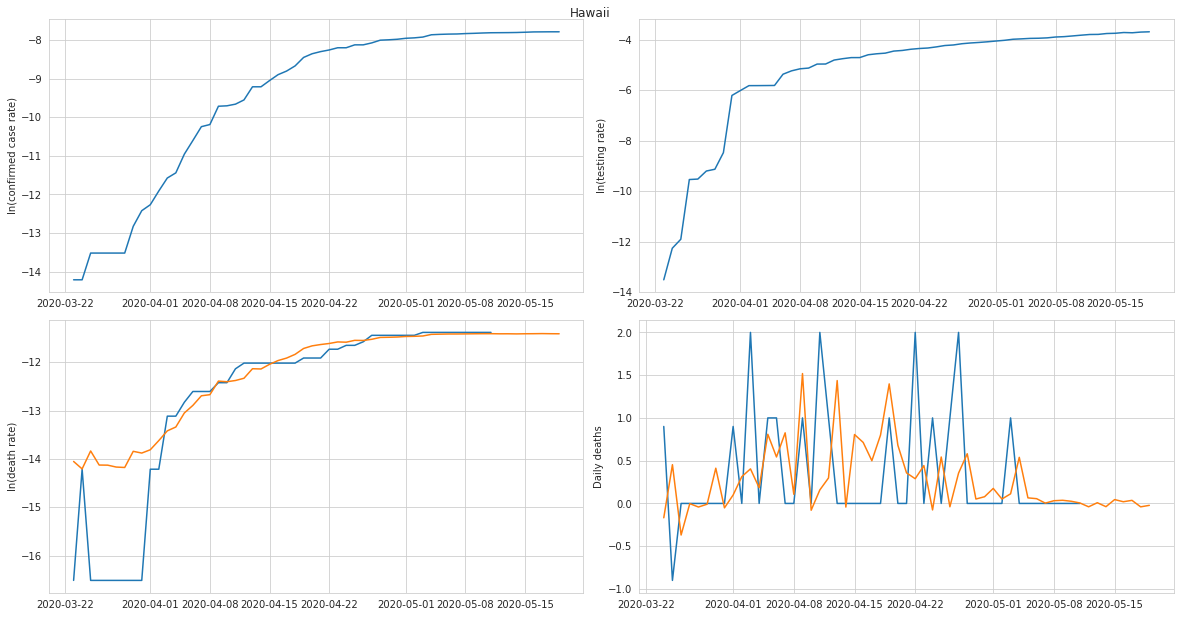

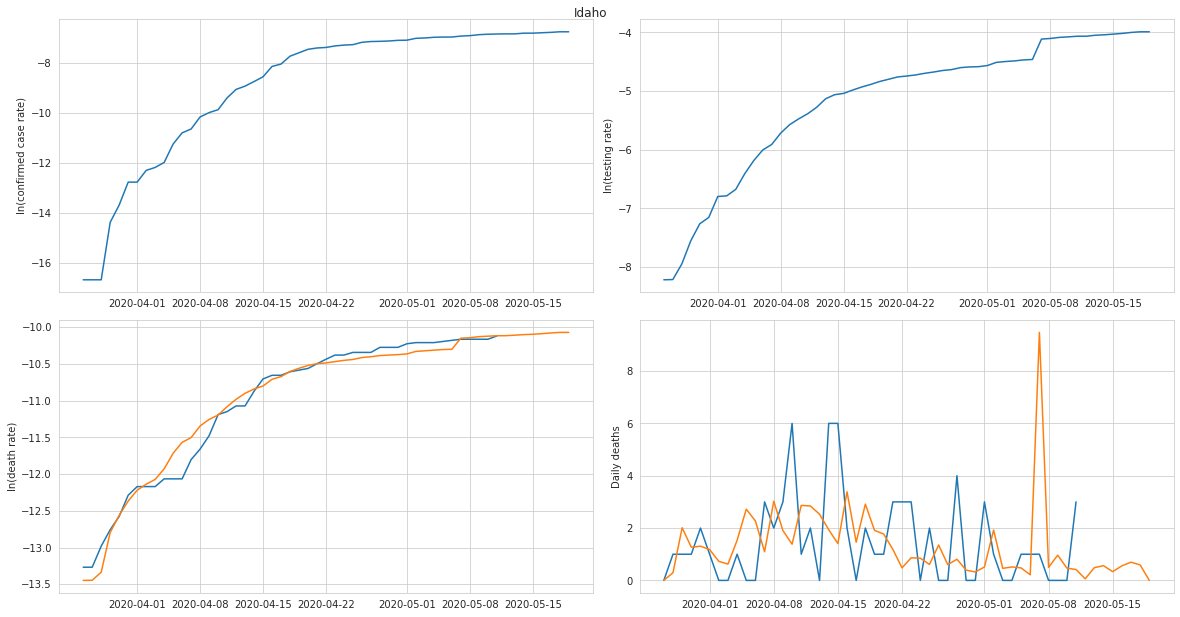

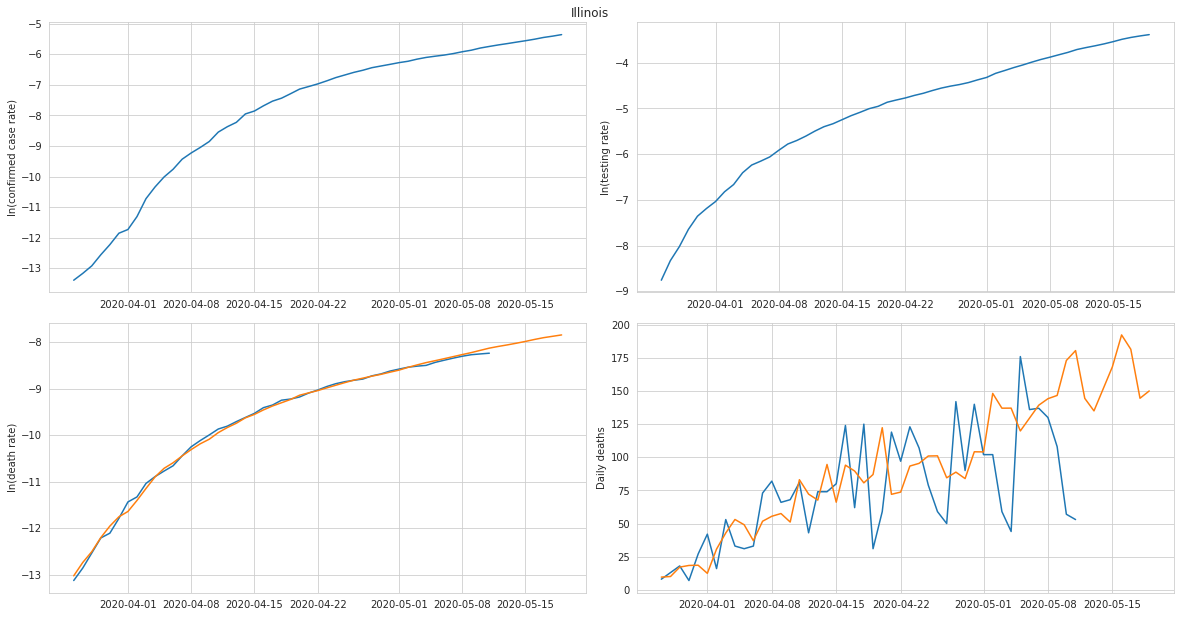

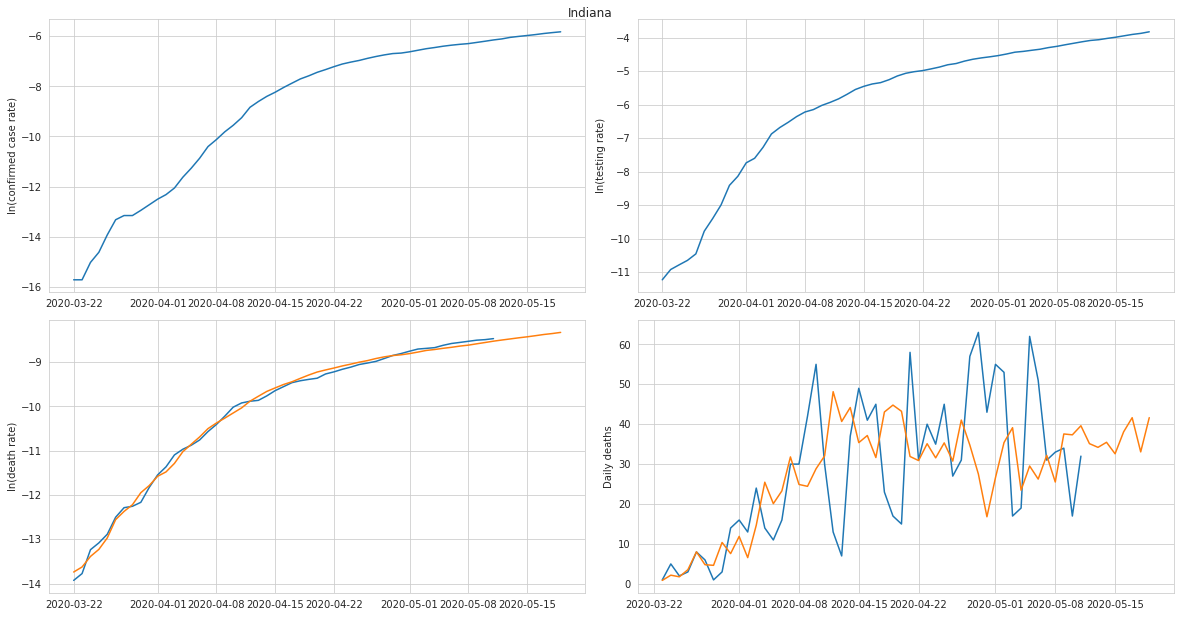

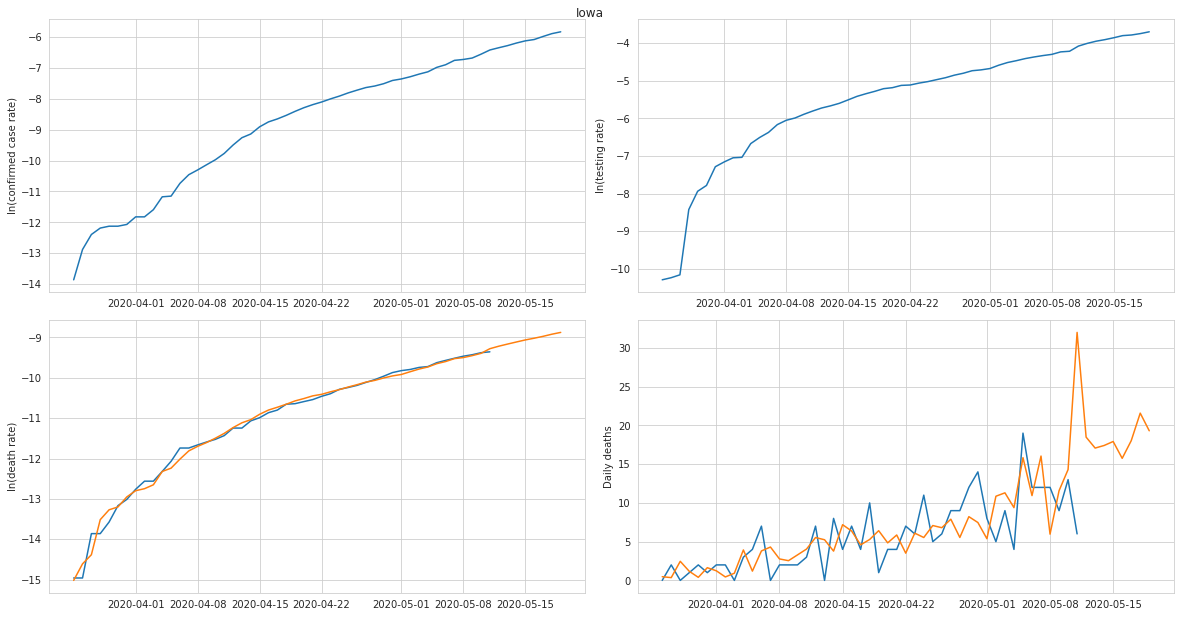

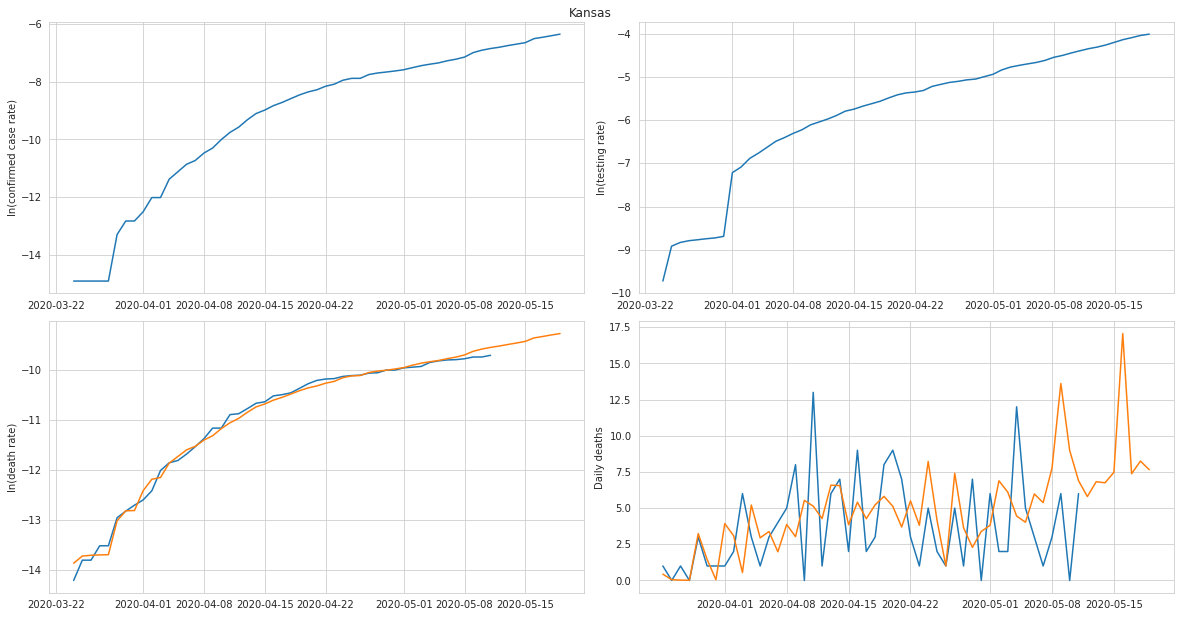

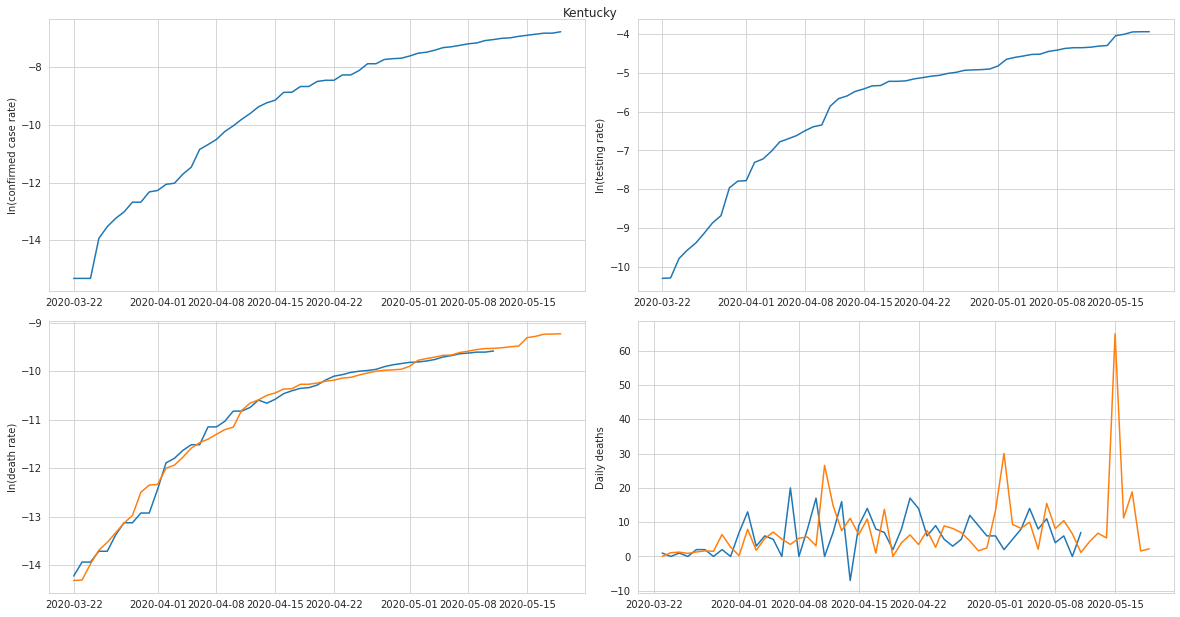

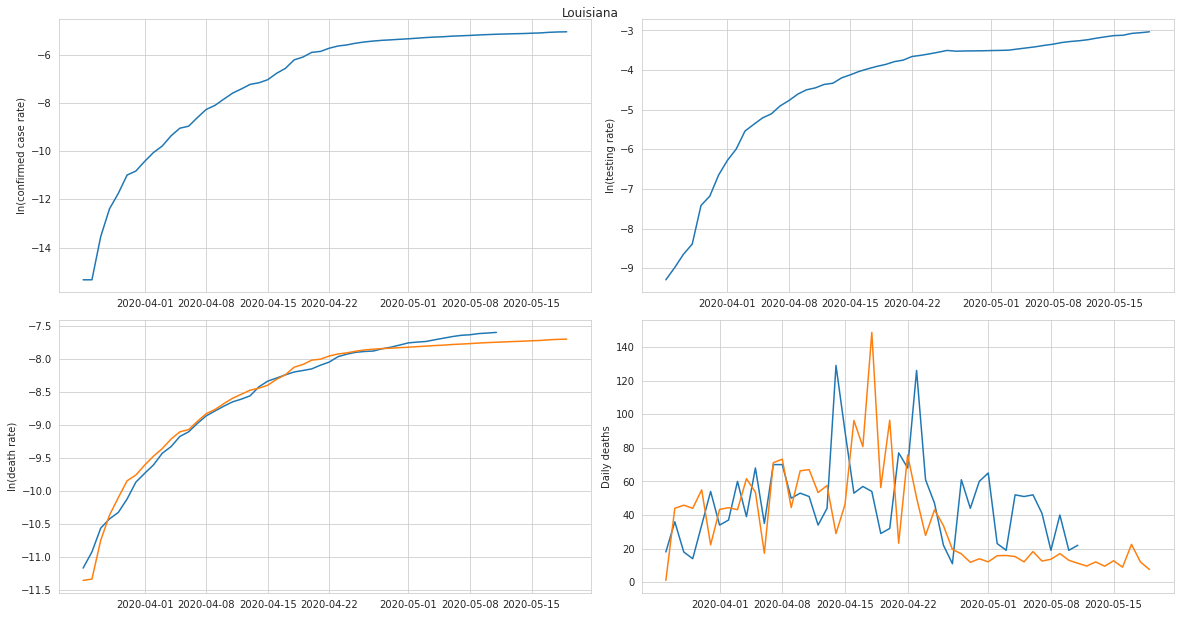

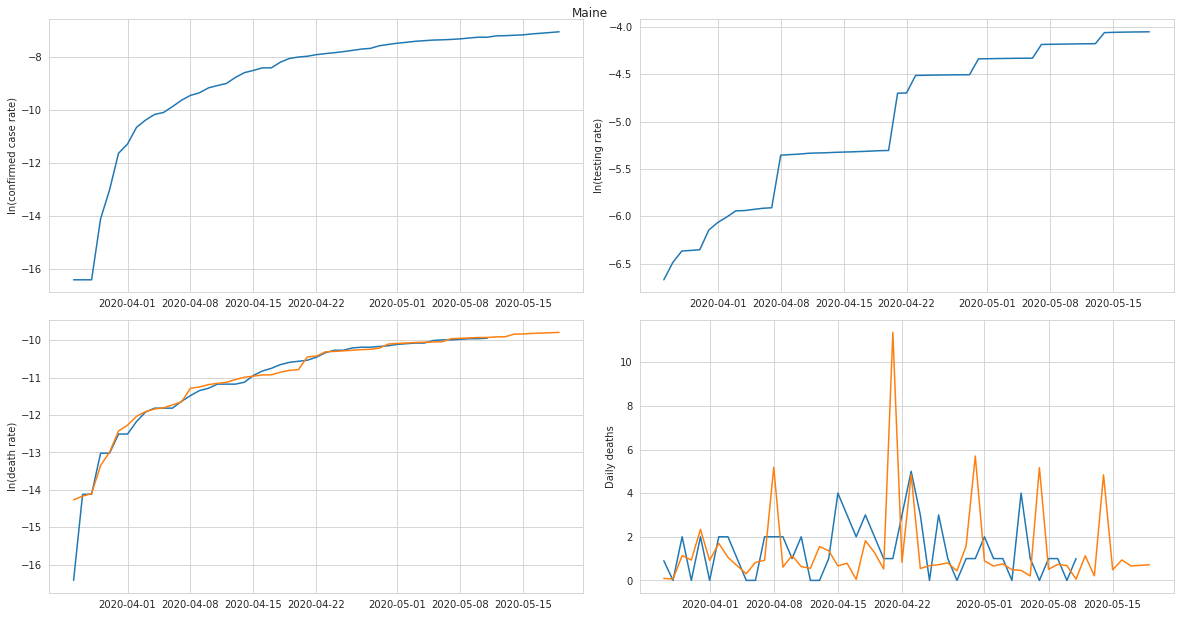

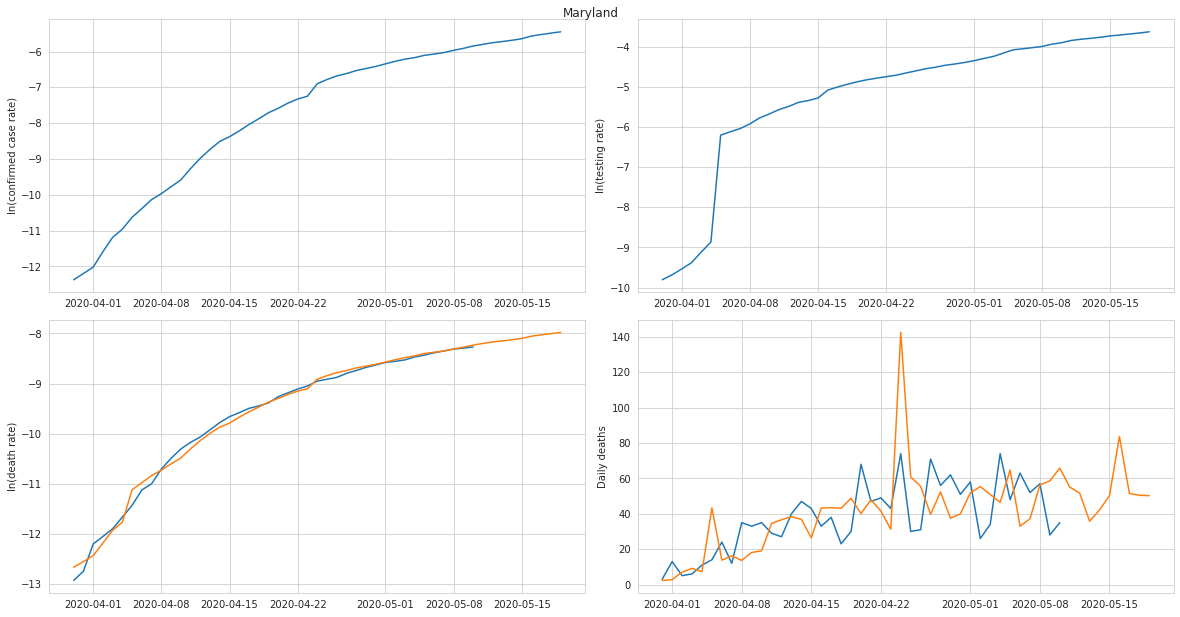

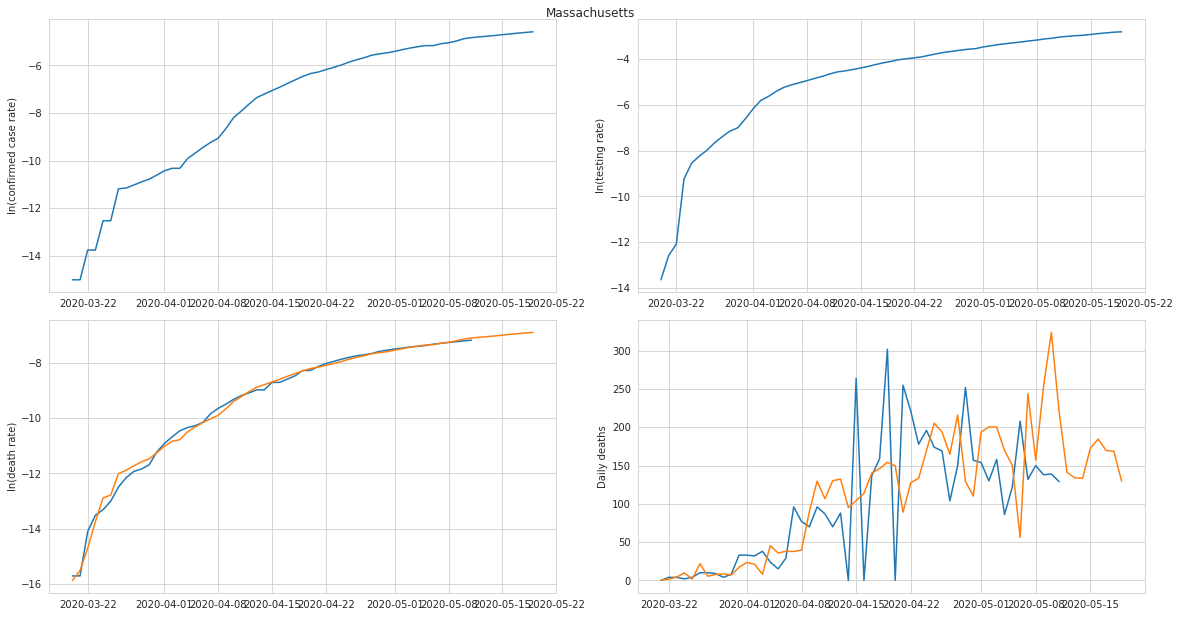

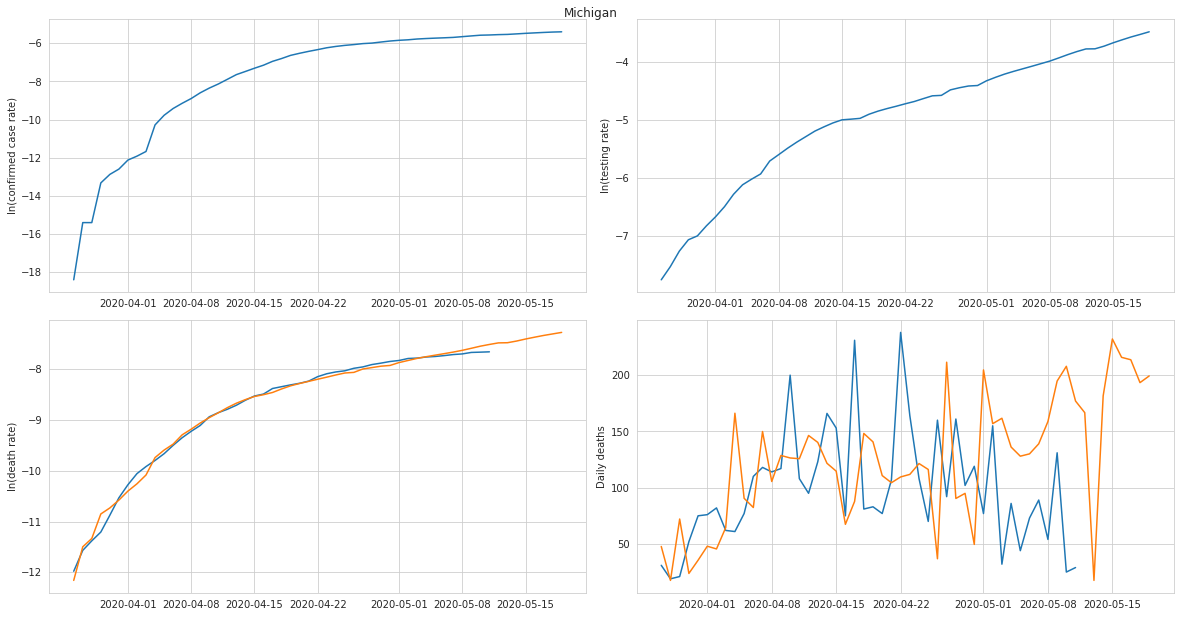

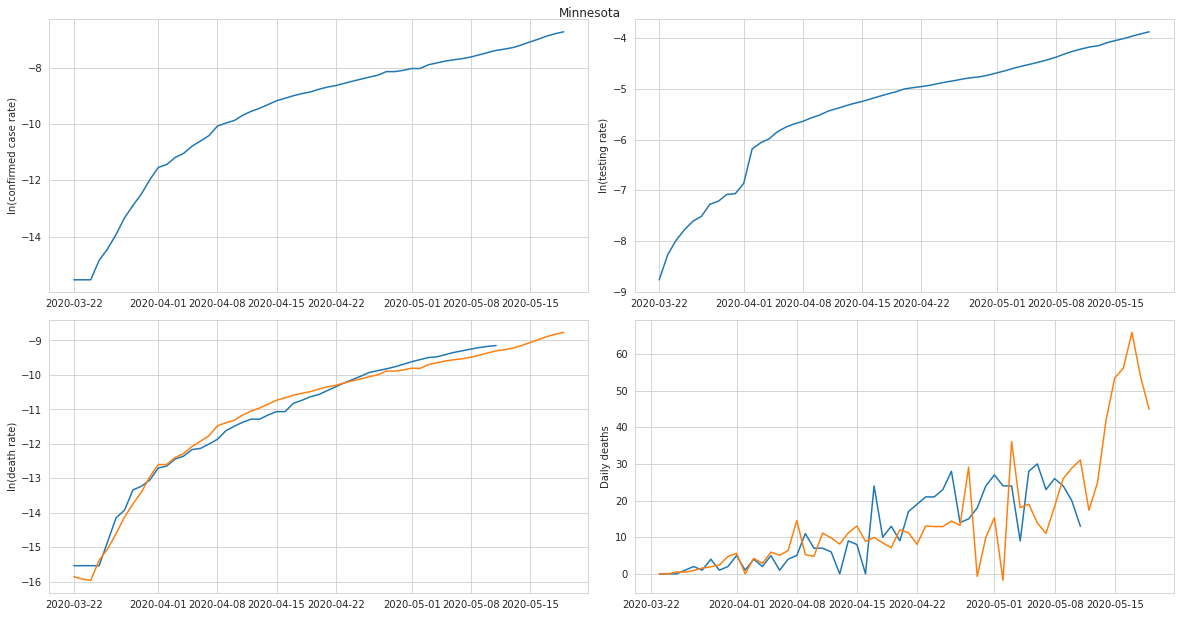

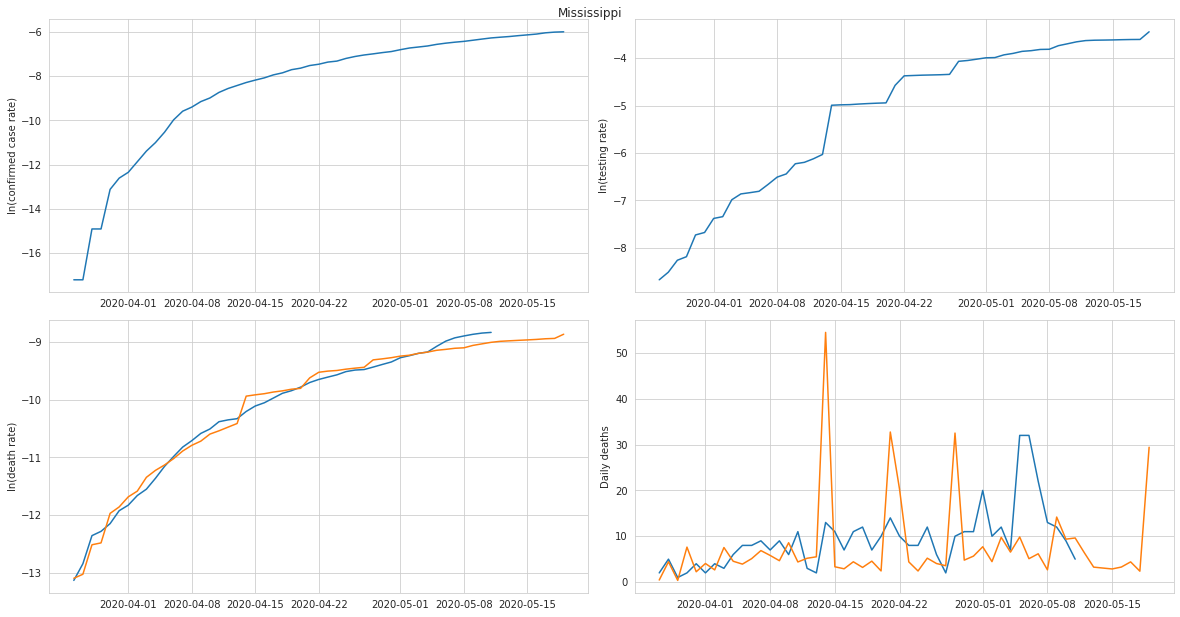

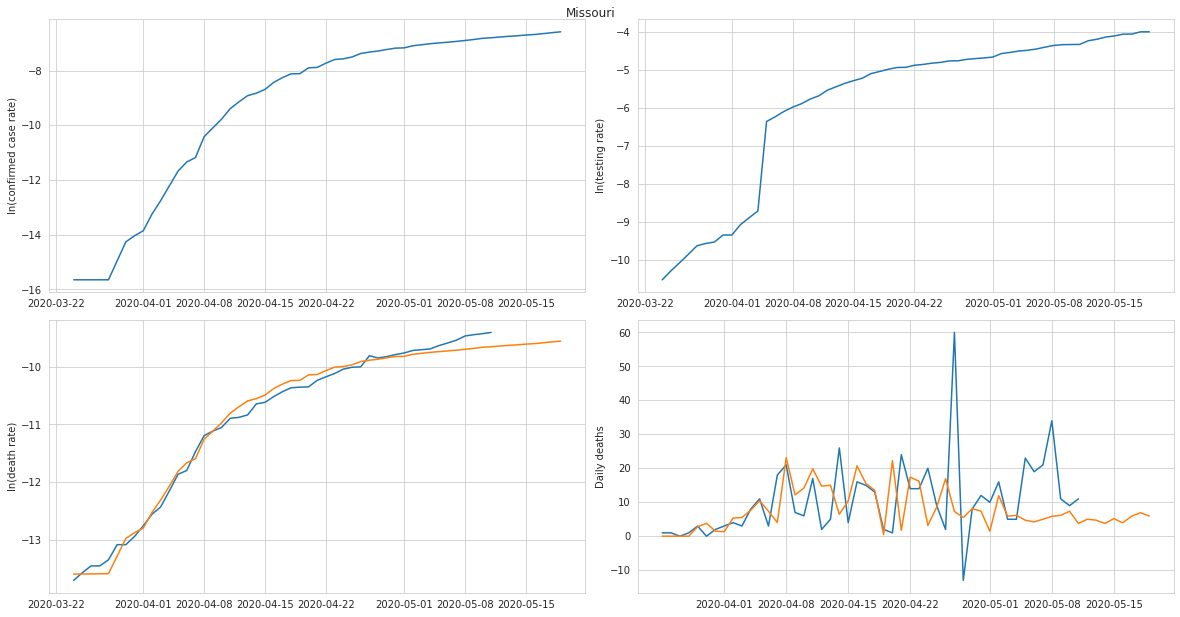

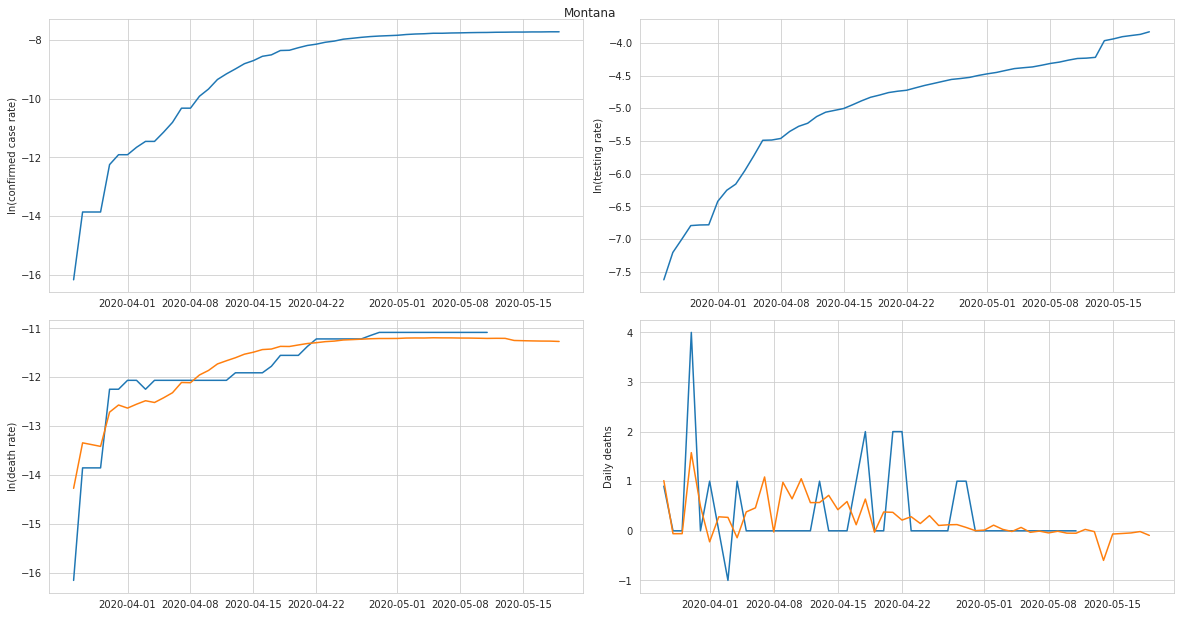

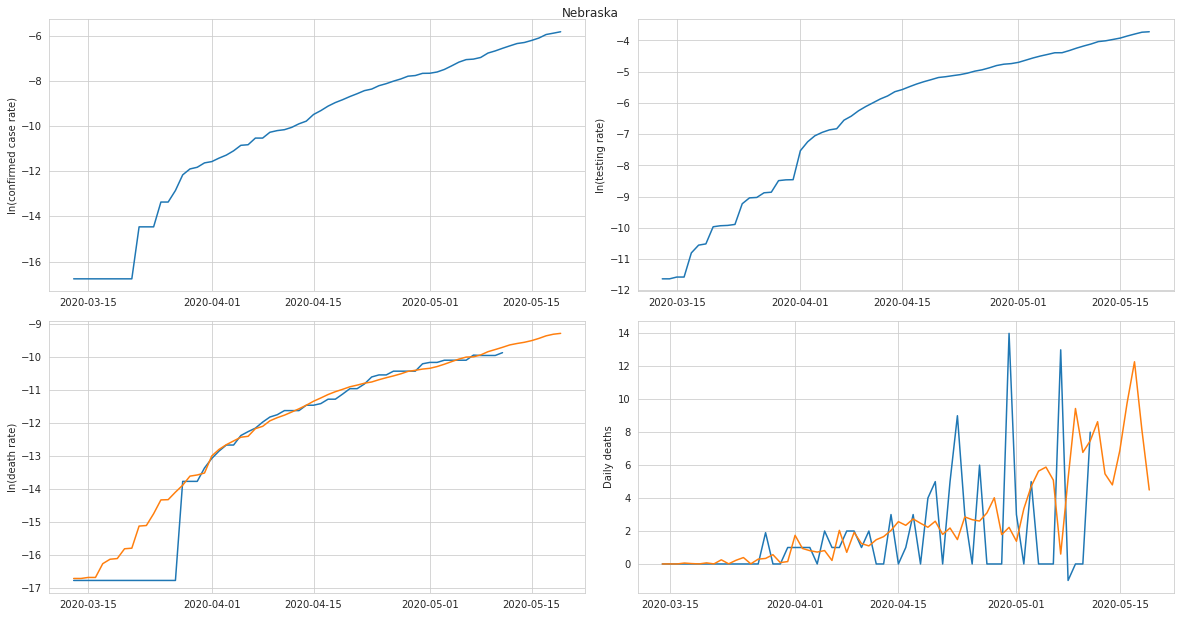

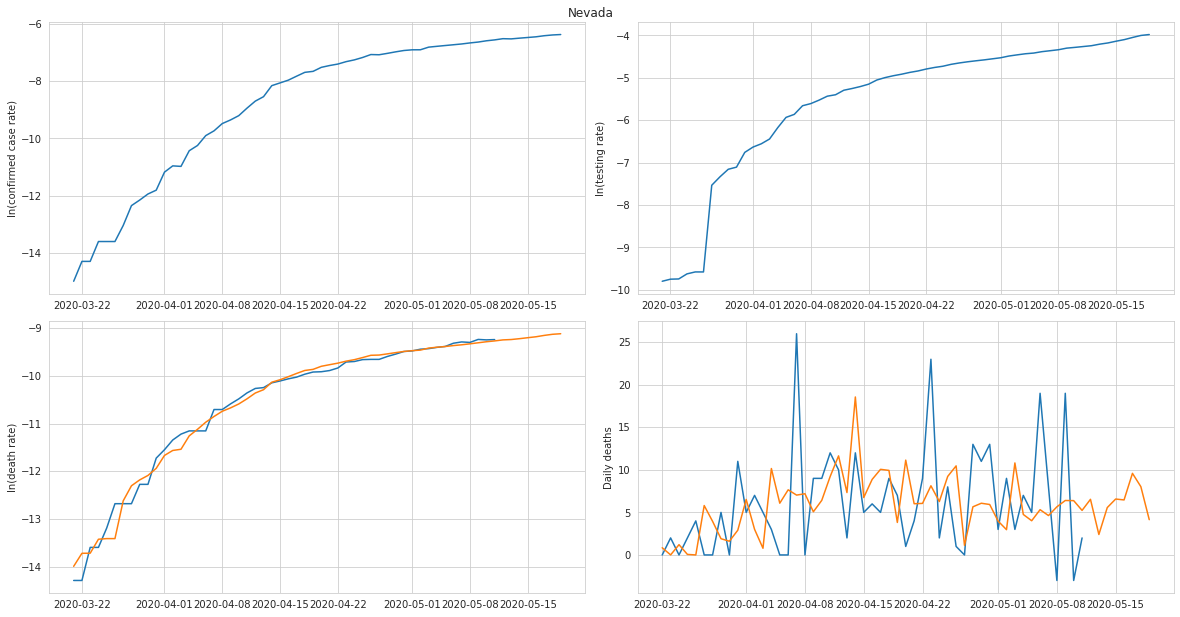

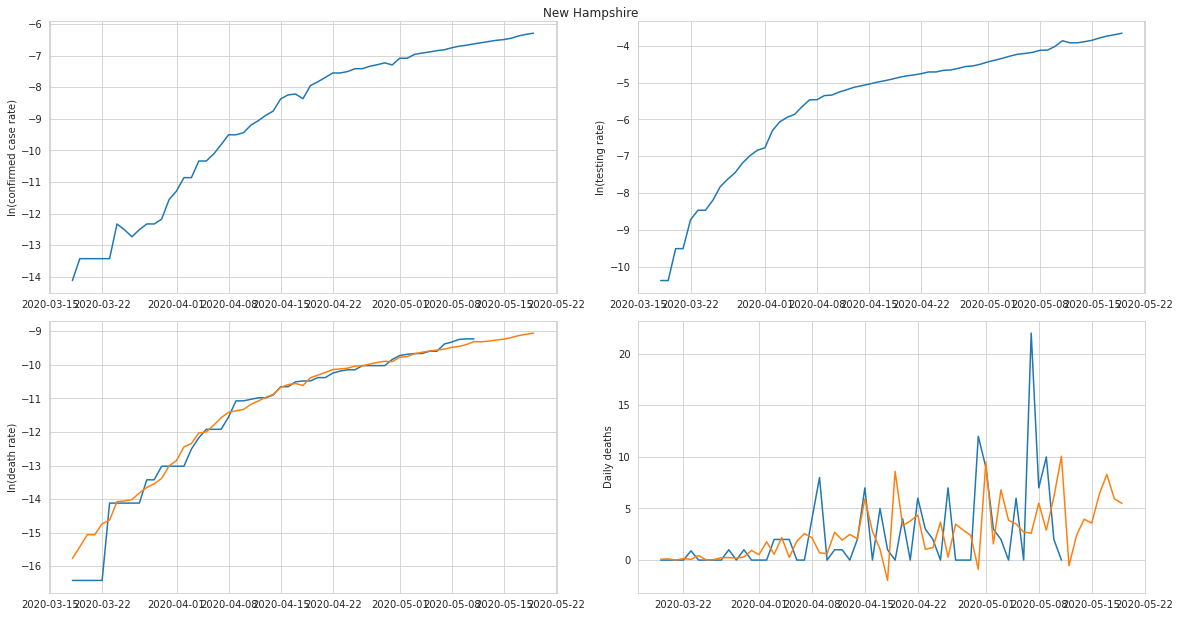

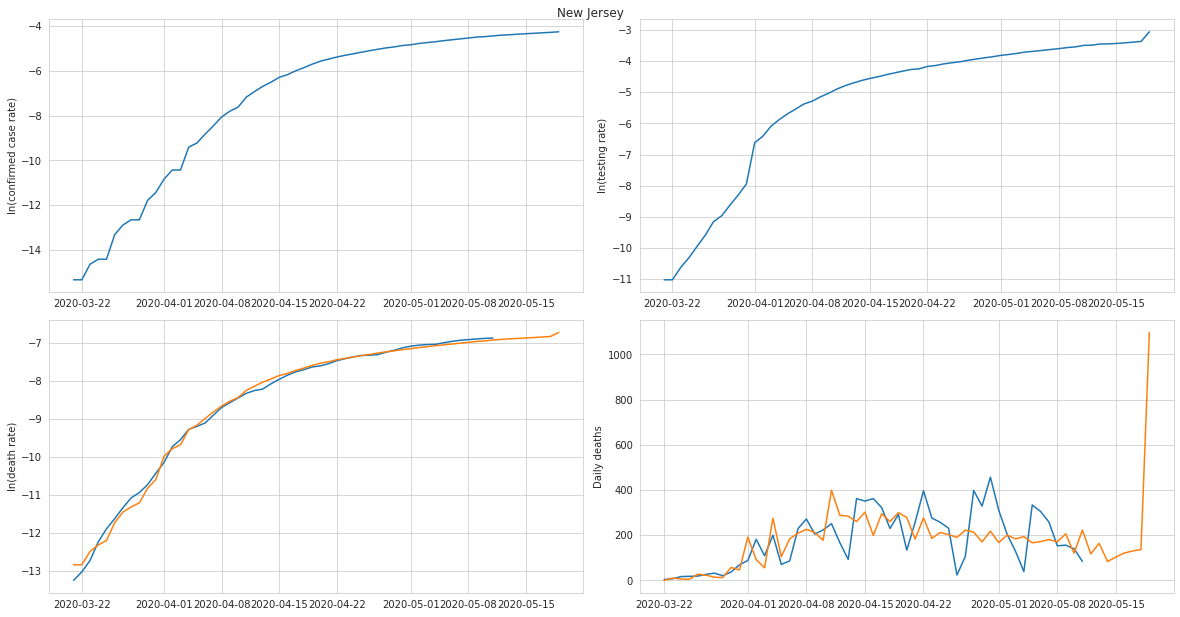

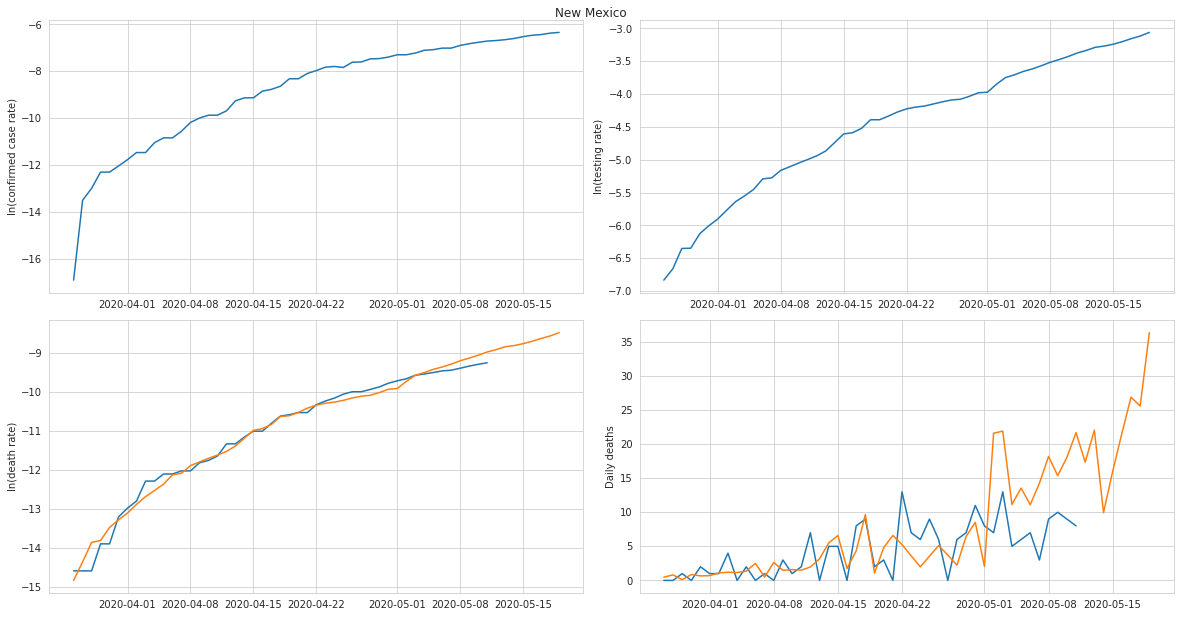

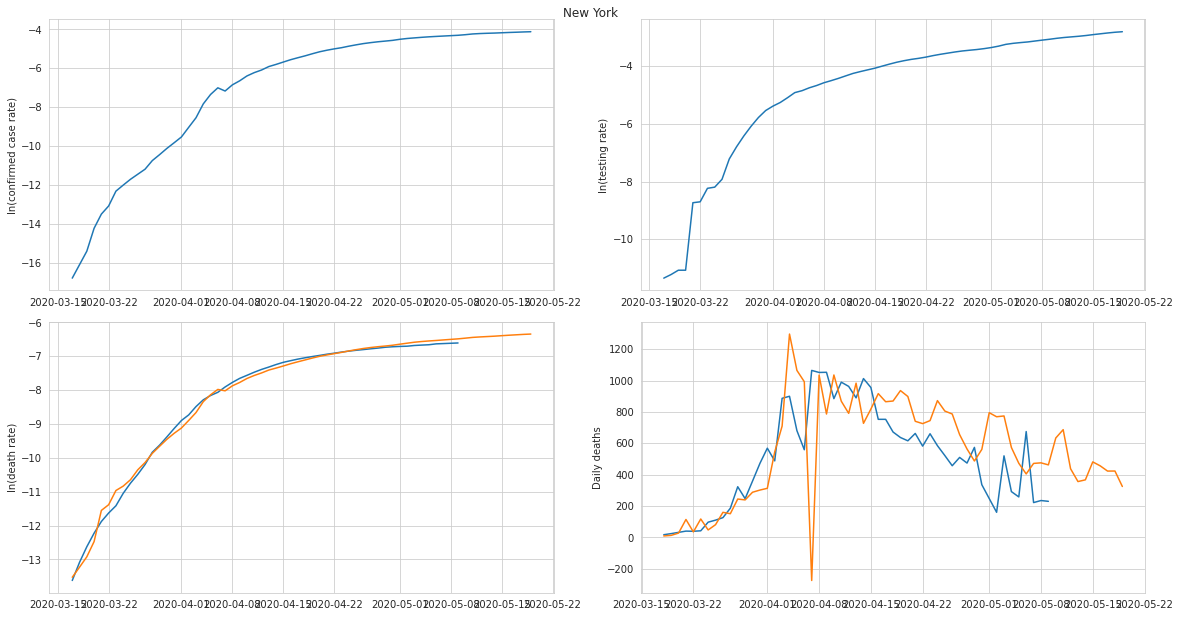

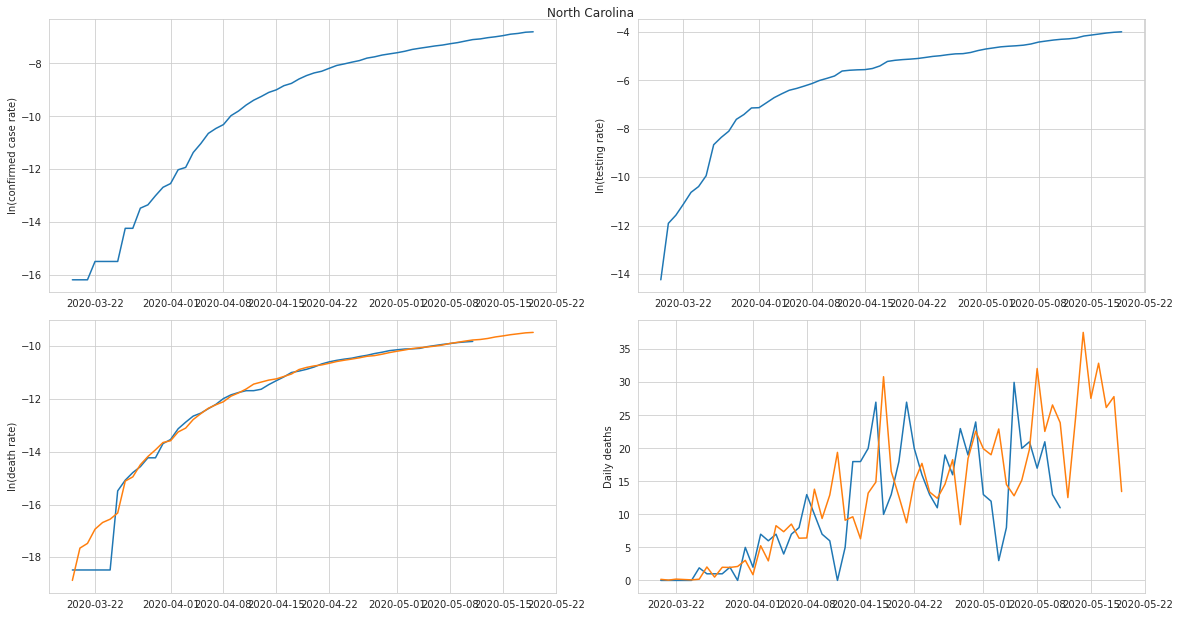

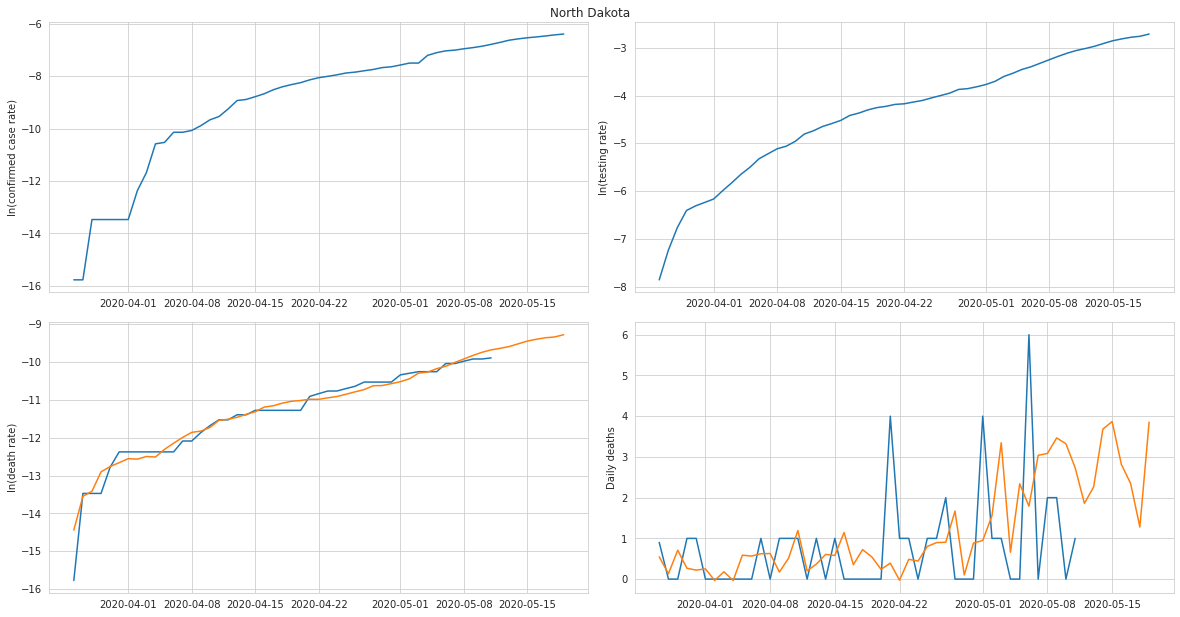

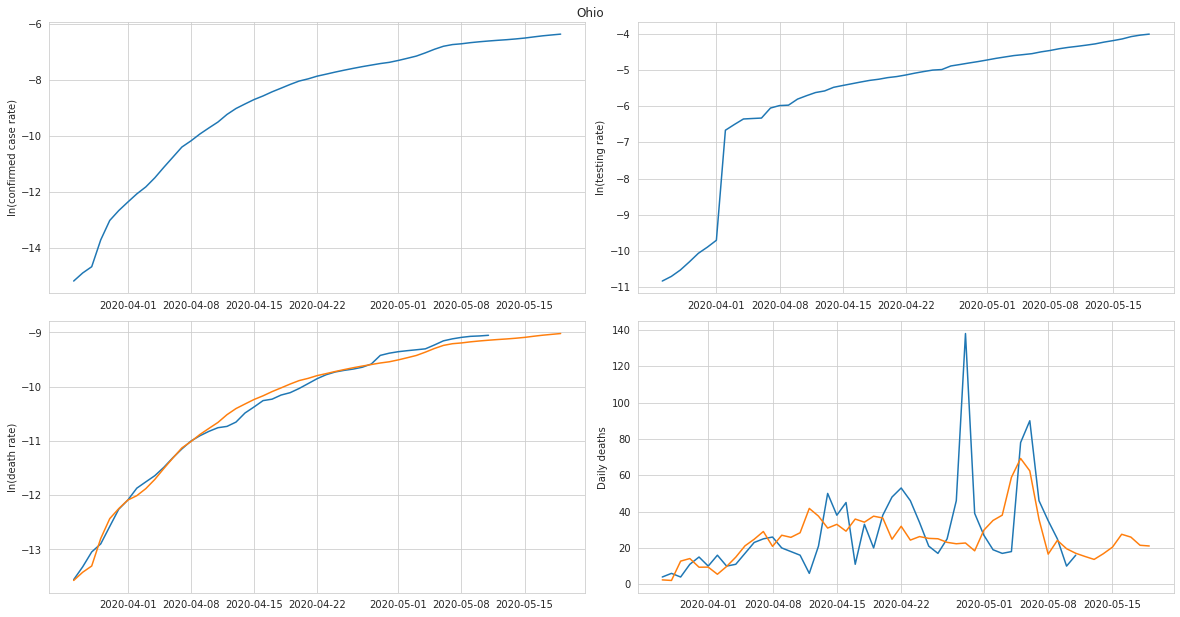

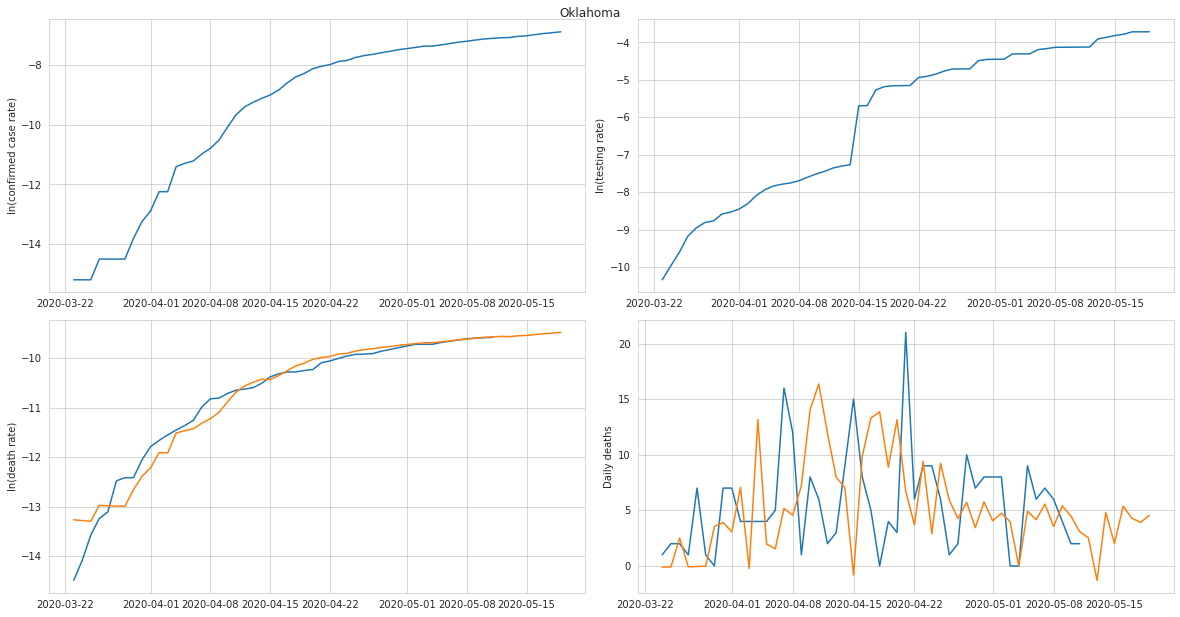

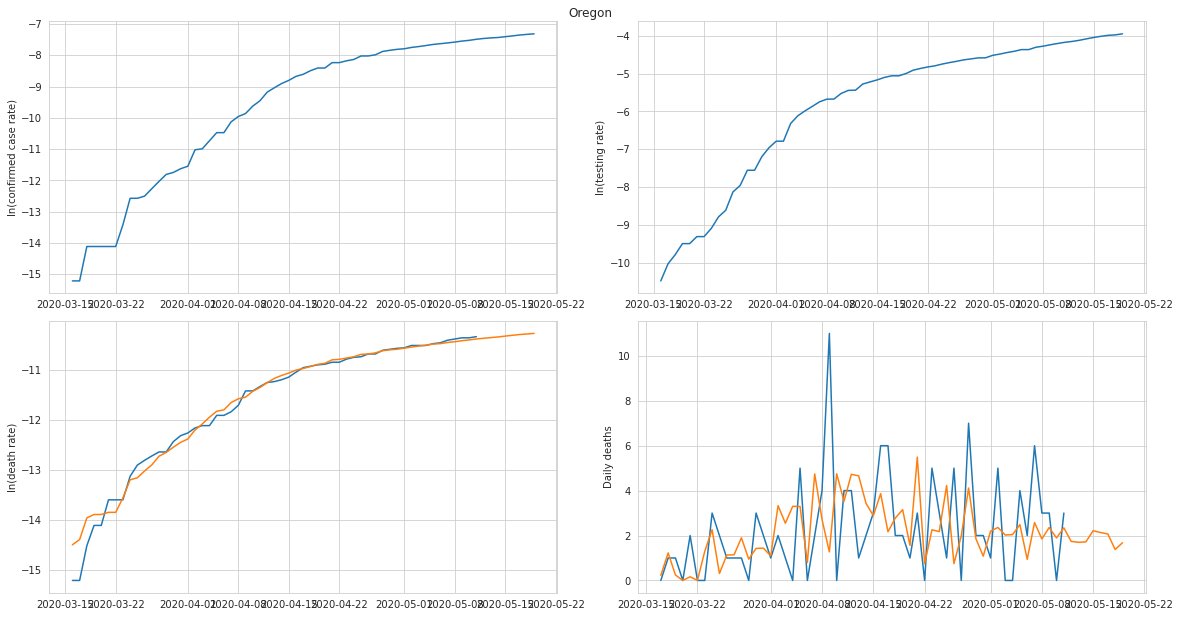

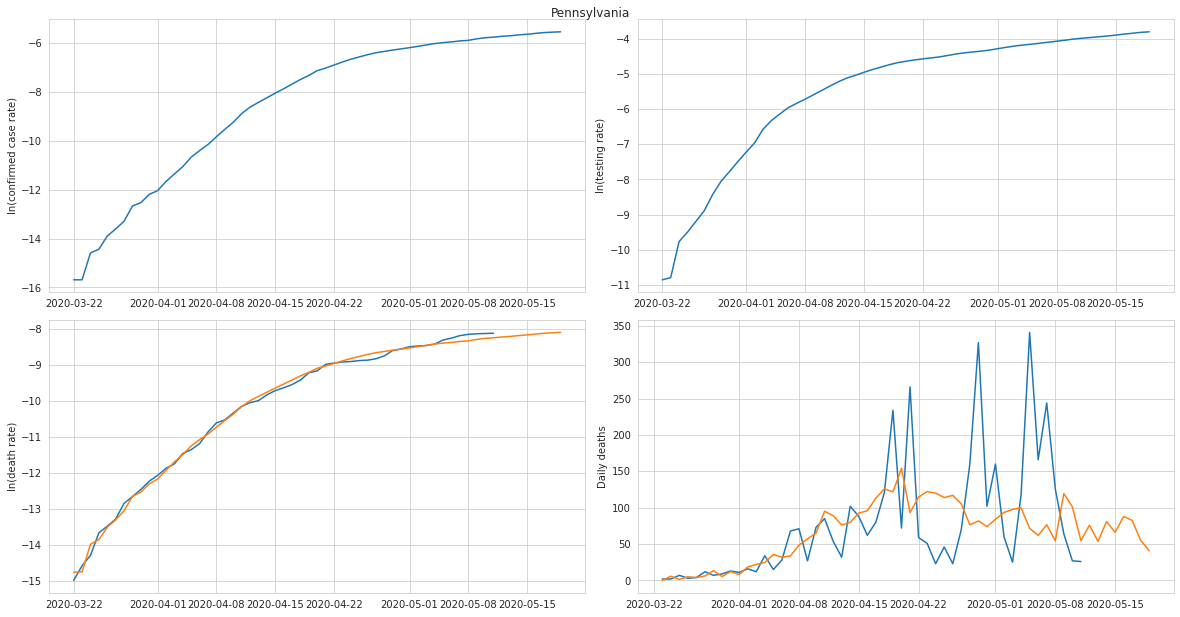

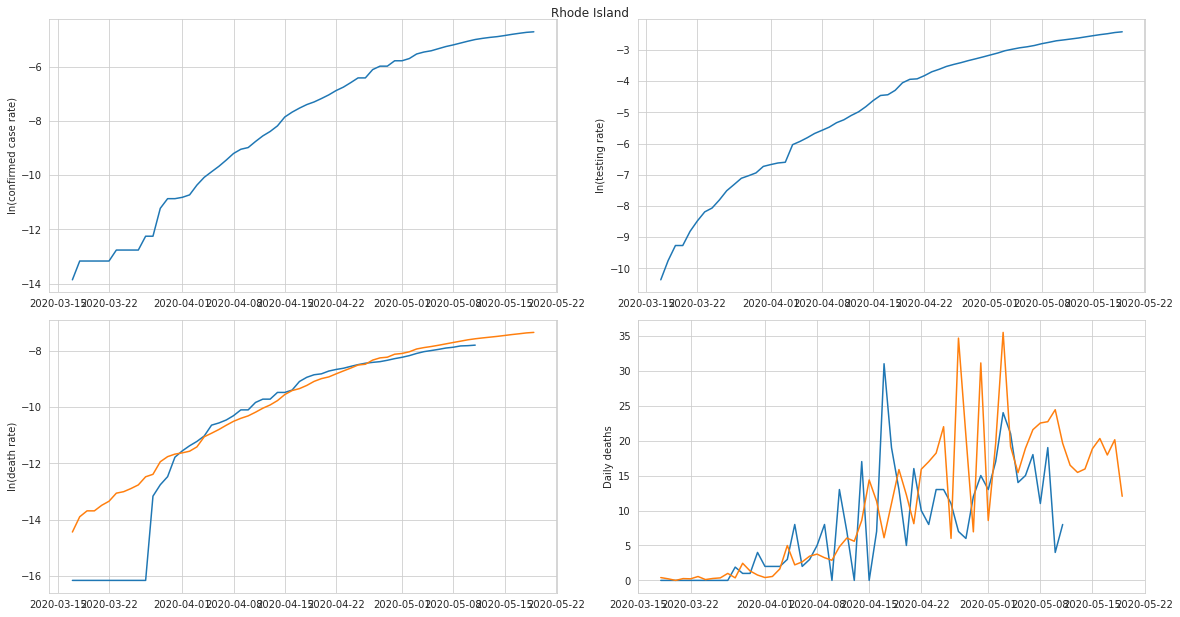

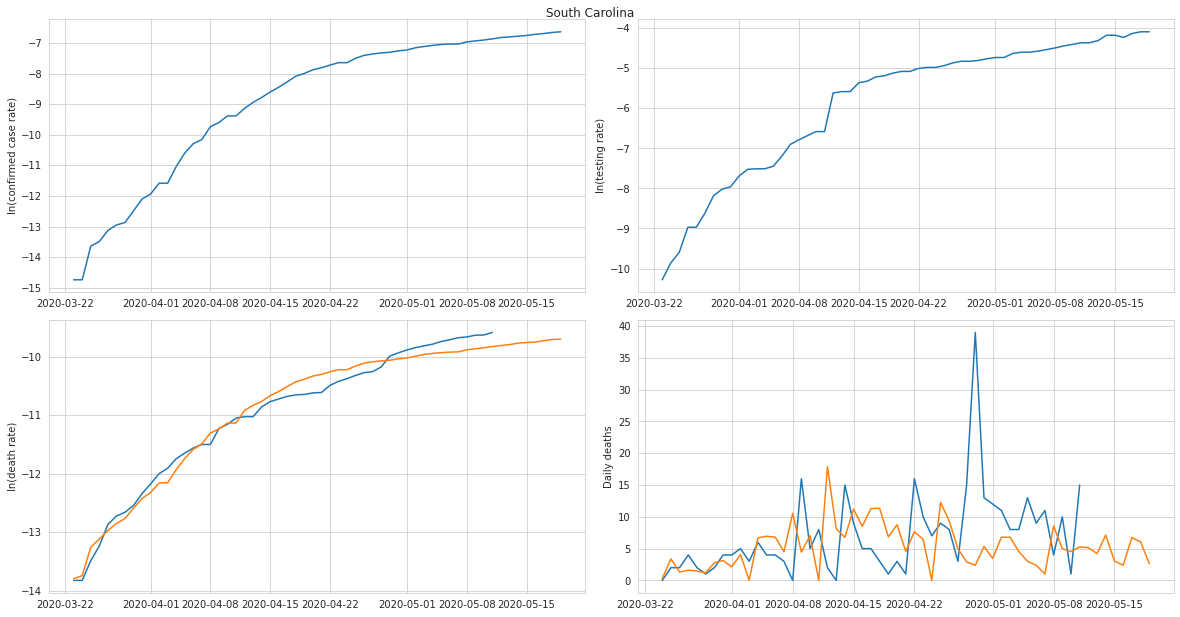

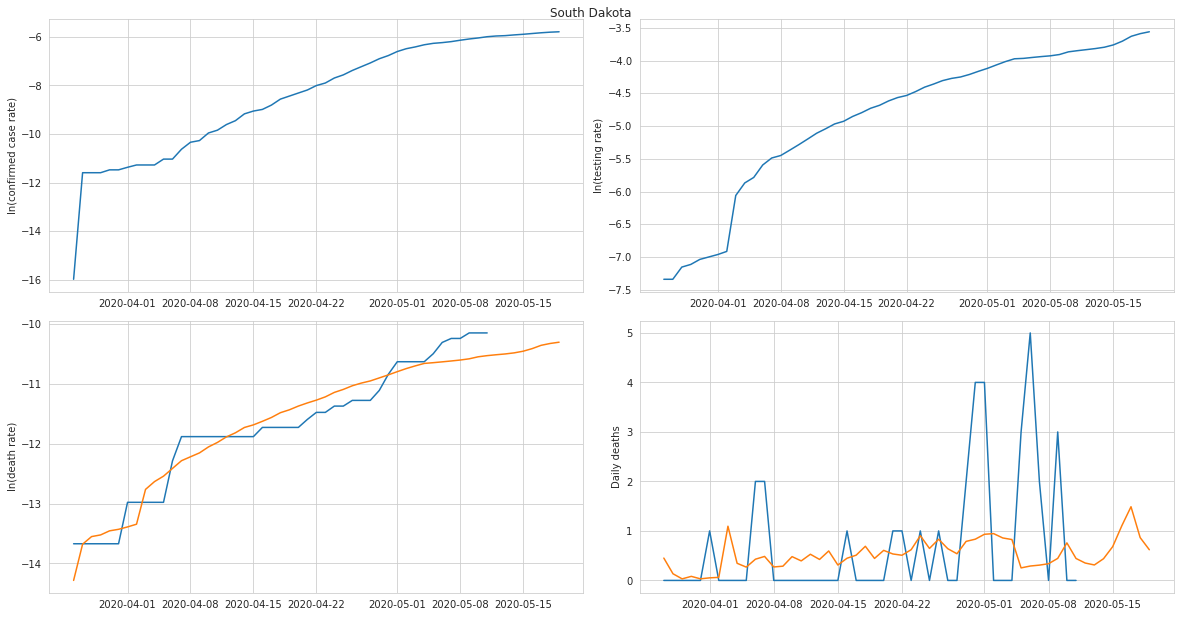

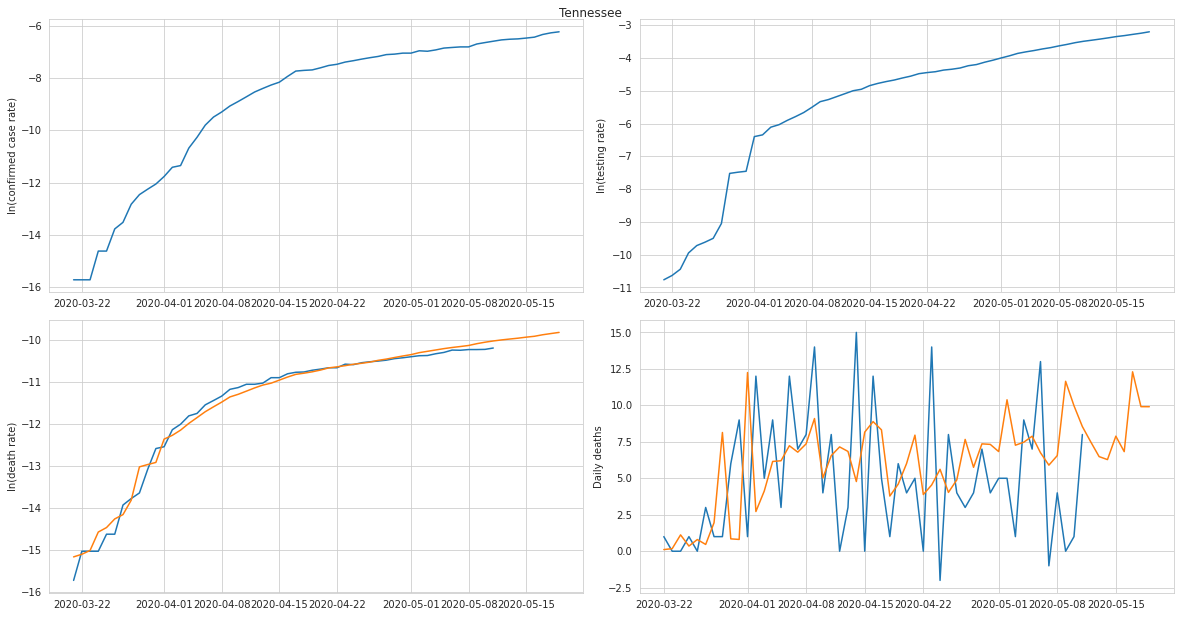

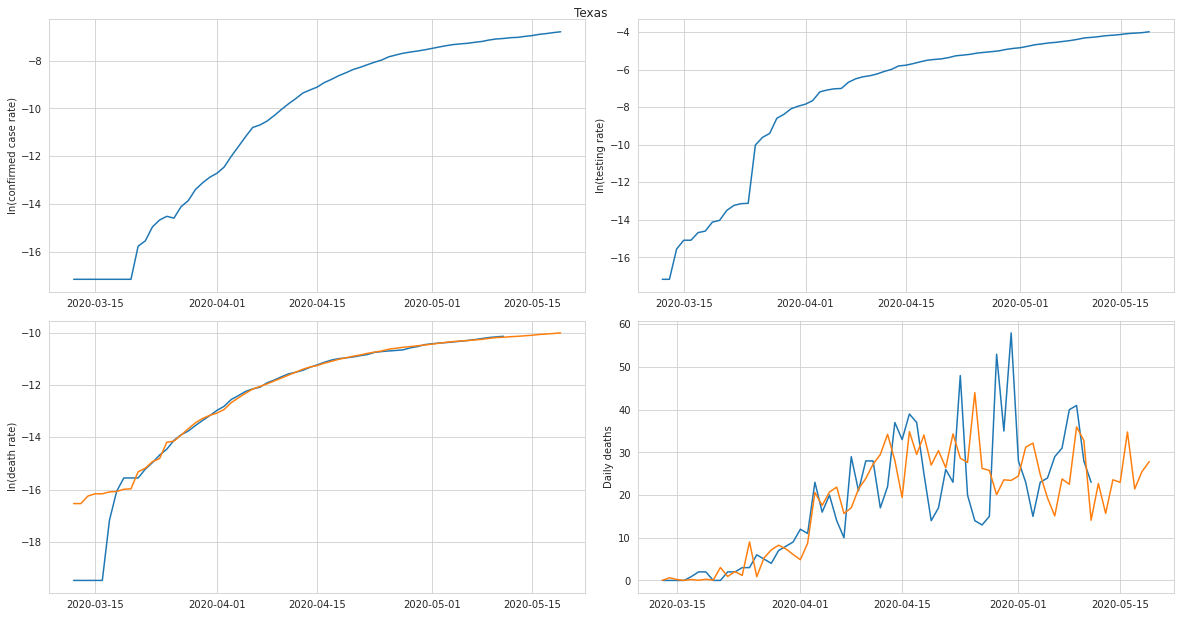

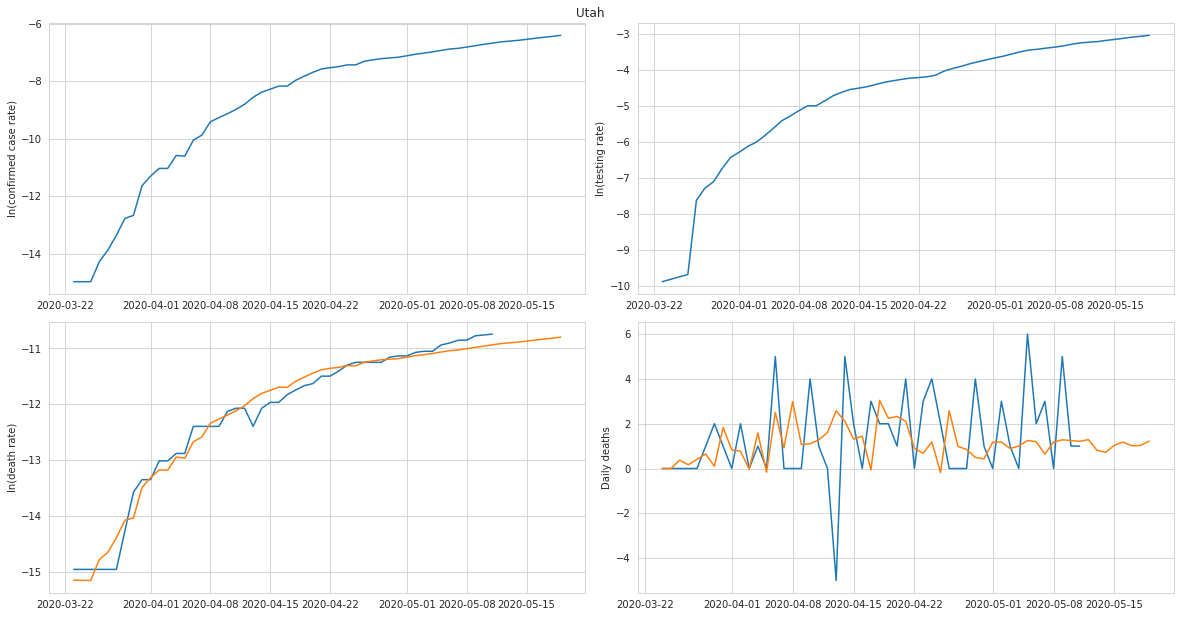

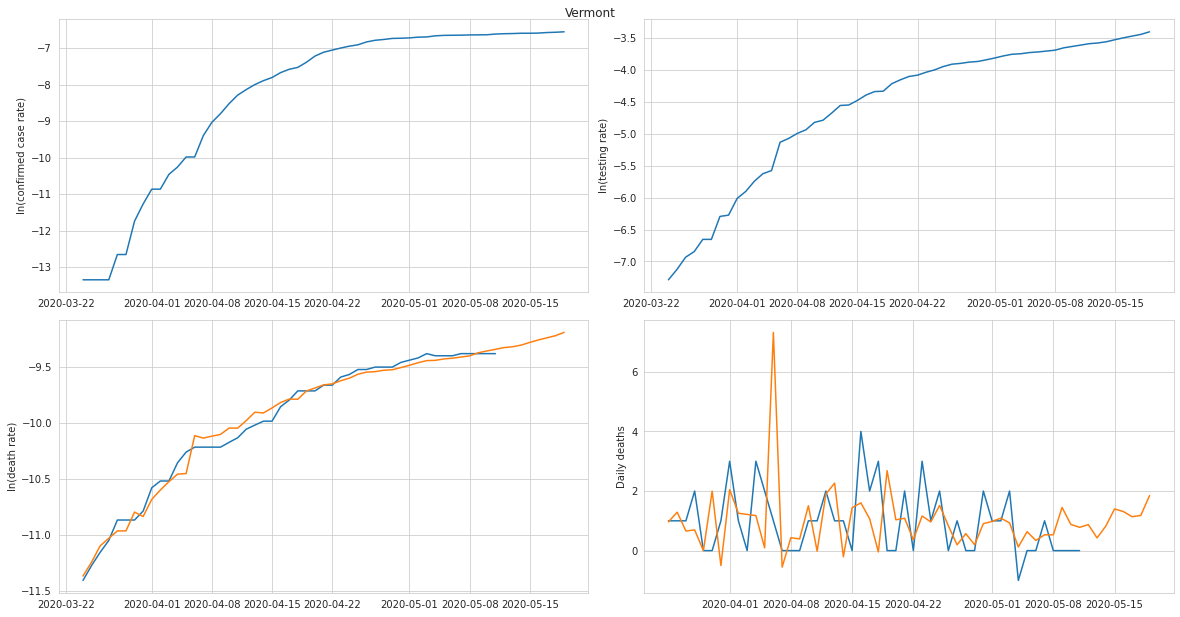

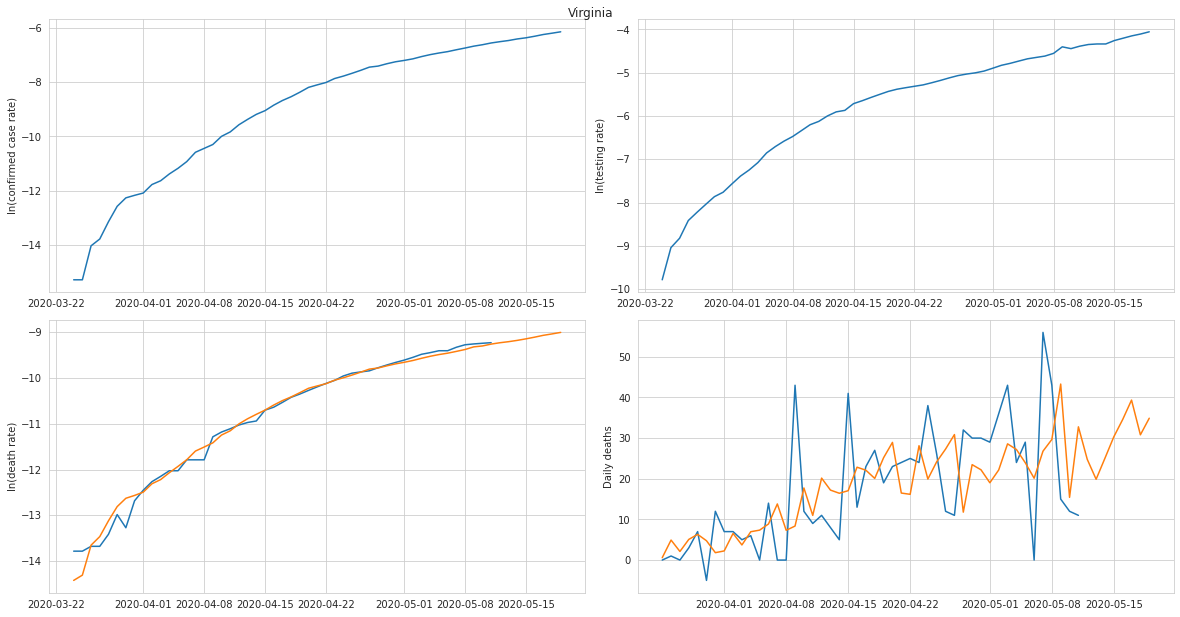

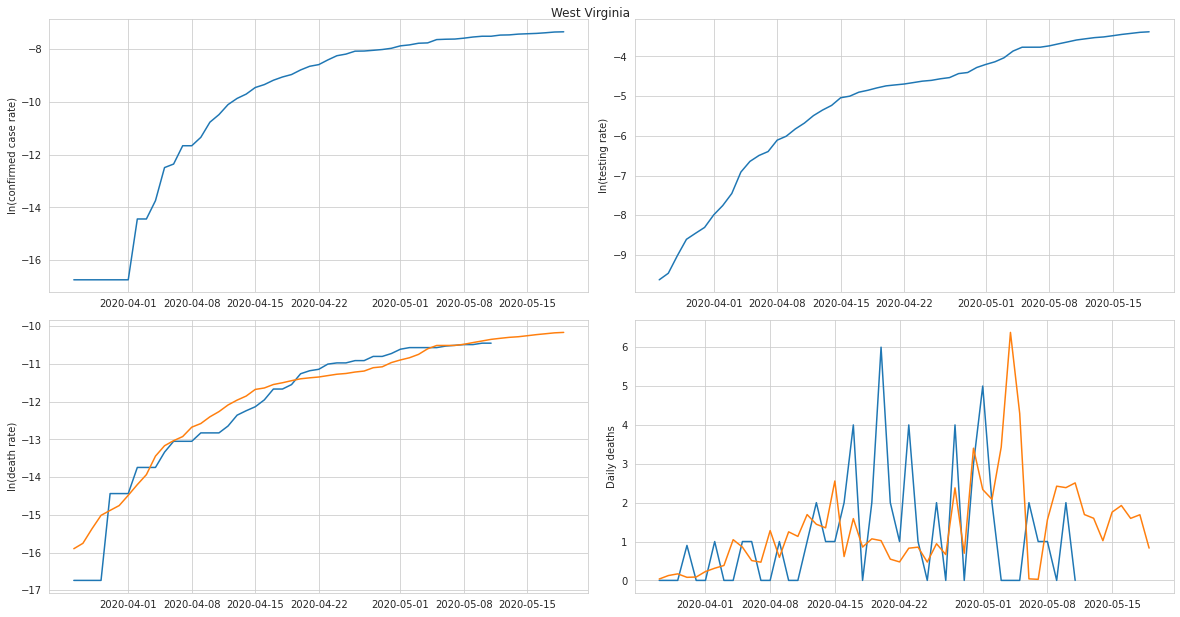

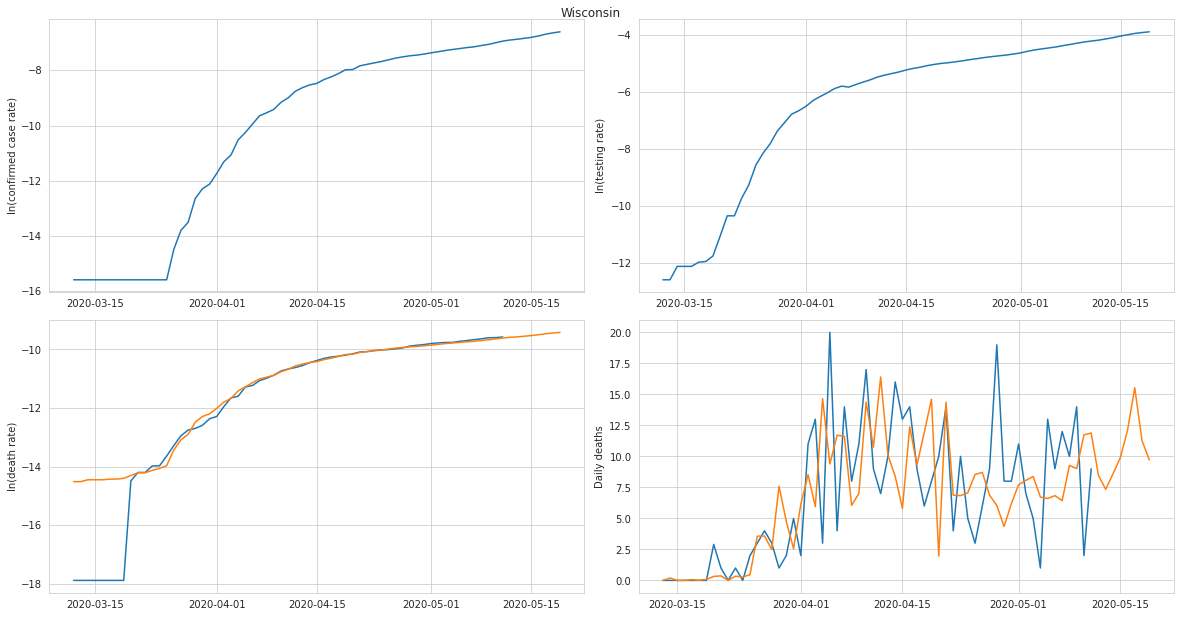

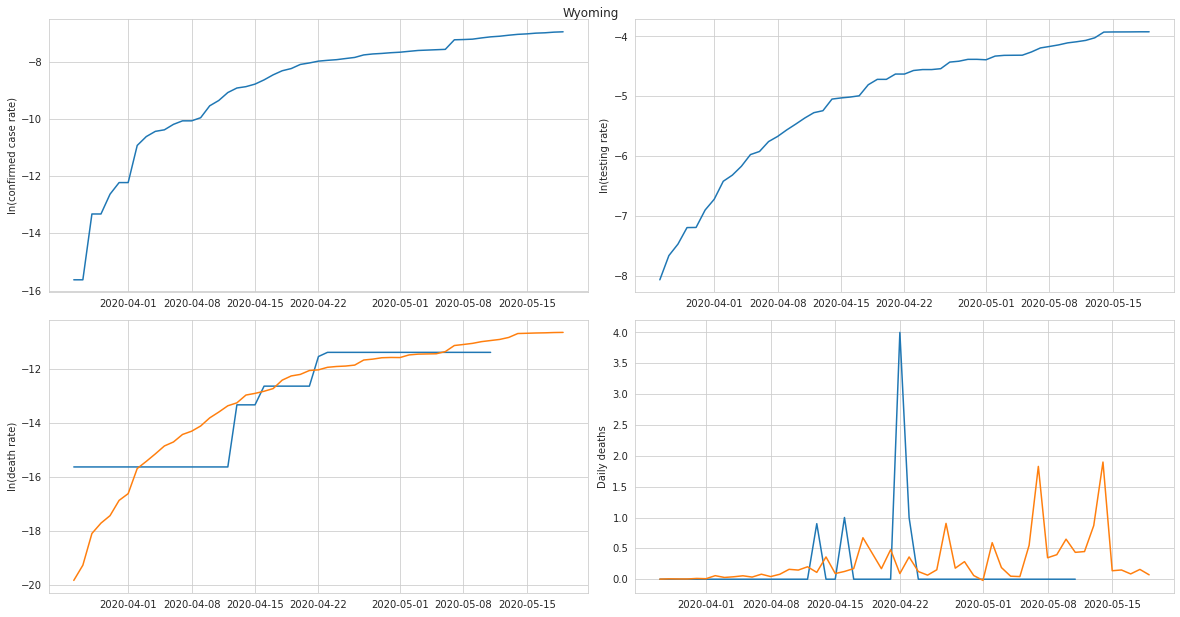

In [5]:
sns.set_style('whitegrid')
with PdfPages('/ihme/homes/rmbarber/covid-19/obs_v_fromcases.pdf') as pdf:
    for location_id in pred_df['location_id'].unique():
        location_name = loc_df.loc[loc_df['location_id'] == location_id, 'location_name'].item()
        
        # get location
        plot_df = pred_df.loc[pred_df['location_id'] == location_id].reset_index(drop=True)

        # get daily deaths
        plot_df['Death rate'] = np.exp(plot_df['ln(death rate)'])
        plot_df = get_daily(plot_df, 'Death rate', 'Daily death rate')
        plot_df['Predicted death rate'] = np.exp(plot_df['Predicted ln(death rate)'])
        plot_df = get_daily(plot_df, 'Predicted death rate', 'Predicted daily death rate')
        plot_df['Daily deaths'] = plot_df['Daily death rate'] * plot_df['population']
        plot_df['Predicted daily deaths'] = plot_df['Predicted daily death rate'] * plot_df['population']

        # plot
        fig, ax = plt.subplots(2, 2, figsize=(16.5,8.5))
        ax[0, 0].plot(plot_df['Date'], plot_df['ln(confirmed case rate)'])
        ax[0, 0].set_ylabel('ln(confirmed case rate)')

        ax[0, 1].plot(plot_df['Date'], plot_df['ln(testing rate)'])
        ax[0, 1].set_ylabel('ln(testing rate)')

        ax[1, 0].plot(plot_df['Date'], plot_df['ln(death rate)'])
        ax[1, 0].plot(plot_df['Date'], plot_df['Predicted ln(death rate)'])
        ax[1, 0].set_ylabel('ln(death rate)')

        ax[1, 1].plot(plot_df['Date'][1:], 
                      plot_df['Daily deaths'][1:])
        ax[1, 1].plot(plot_df['Date'][1:], 
                      plot_df['Predicted daily deaths'][1:])
        ax[1, 1].set_ylabel('Daily deaths')

        plt.suptitle(location_name, y=1.0025)
        plt.tight_layout()
        pdf.savefig()
